You can install AART by simply typing in your terminal:

In [1]:
!pip install aart

  Using cached aart-2.0.0-py3-none-any.whl (47 kB)


For a detailed description of the code behind the AART package, see Ref. [1]. Now, let us load the packages we use in conjuction with AART throughout this notebook.

In [2]:
import numpy as np
import aart
from aart import lensingbands as lb
from aart import mkplot
from aart import radialintensity as ri
from aart import raytracing as rt
from aart import visamp as va
from aart import iImages as im
from aart import iMovies as imov
from aart import parameters
import h5py
import matplotlib.pyplot as plt
import scipy
import math
from scipy.optimize import curve_fit
from scipy.ndimage import zoom
from matplotlib.ticker import FormatStrFormatter

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
plt.rcParams.update({
    "font.size" : 14,                   # Set font size to 11pt
    "axes.labelsize": 14,               # -> axis labels
    "legend.fontsize": 12,              # -> legends
    "text.usetex": True,
    "text.latex.preamble": (r'\usepackage{lmodern}'), # LaTeX preamble
    "font.family": 'Latin Modern Roman',
})

Defining constants for unit conversions:

In [4]:
dM=5.214795112e23  # Distance to M87 in meters
psi=1.07473555940836 # Mass of M87 1 /psi= 6.2e9 Kg
Gc=6.67e-11 # G constant [m^3 kg^-1 s^-2]
cc= 2.99792458e8 # c constant [m/s]
Msc=1.988435e30 # Solar Mass [Kg]
MMkg= 6.2e9*psi*Msc # [Kg]
MM87=MMkg *Gc/cc**2 # Mass of M87 in meters, i.e., (psi*6.2*10^9) psi ("Best fit") Solar Masses 
sizeim=MM87 # Size of M in meters
muas_to_rad = np.pi/648000 *1e-6 #1 microarcsec in radians
unitfact=1/(muas_to_rad*1e9)
M_to_muas=np.arctan(sizeim/(dM))/muas_to_rad

We now define the paths for saving simulated data, the circlipses fits, and the various figures we produce.

In [5]:
bh_obs_data_path='Results/Raytracing/' # Folder for storing the raytracing data
fit_path='Results/Fits/' #Folder for storing the fits
fig_path='Results/Figures/'#Folder for storing the figures

We will now use the `generate_dict` function from the module `parameters` to generate a dictionary containing all the necessary parameter values for our simulations. This function requires three arguments: `spins`, `i_angles` (observer inclination angles), and `fudge`, the factor for enhancing the $n=1$ and $n=2$ photon ring intensities. All of these are iterable objects. The remaining arguments all have default values that one can choose to change or not. 

Note the fudge still needs to be specified if one computes the Beloborodov approximation, even though it will not be used in the calculation.

To see all the possible arguments for each of the functions used in this notebook, you can use the library `inspect` as follows:

In [6]:
import inspect

In [7]:
inspect.getfullargspec(parameters.generate_dict)

FullArgSpec(args=['spins', 'i_angles', 'fudge', 'dBH', 'psi', 'D_obs', 'sub_kep', 'betar', 'betaphi', 'radonfile', 'bvapp', 'p_image', 'limits', 'dx0', 'dx1', 'dx2', 'radonangles', 'i_fname', 'disk', 'i_frame', 'i_tM', 'f_tM', 'snapshots', 'mup', 'gammap', 'sigmap', 'gfactor', 'maxbaseline', 'npointsS', 'nthreads', 'Ncut', 'path'], varargs=None, varkw=None, defaults=(5.214795112e+23, 1.07473555940836, 10000, [1.0], [1.0], [1.0], 0, 0, 1, 25, 0.02, 0.02, 0.02, [0, 90], 'inoisy.h5', 'dynamical', 0, 0, 12, 12, [1.0], [-1.5], [0.5], 3, 500, 100, 4, 0, './Results/'), kwonlyargs=[], kwonlydefaults=None, annotations={})

For a brief description of the various arguments of a function, and any restrictions on their values, please refer to the relevant module's .py file, e.g., for a description of the BH parameters taken as argument in `parameters.generate_dict`, refer to the `parameters.py` file.

Of particular note are the group of parameters, which we will refer to collectively as (\*) :

- fudge ($\zeta$): Geometrical factor
- sub_kep ($\xi$) : Sub-Keplerian factor
- betar ($\beta_r$): Radial velocity factor
- betaphi ($\beta_\phi$): Angular velocity factor
- gammap ($\gamma$): Controls profile asymmetry
- mup ($\mu$): Controls location of profile peak
- sigmap ($\vartheta$):Controls the profile width

These are all iterable objects that must be the same size as _spins_, and must be indexed according to the particular profiles for which you would like to run a simulation. In particular, if we had the following:

- spins ($a$)= [0.5, 0.94]
- i_angles ($\theta_{\rm obs}$) = [17, 30]


- fudge = [0.5, 1.5]
- sub_kep = [1.0, 1.1]
- betar = [1.0, 1.1]
- betaphi = [1.0, 1.1]
- gammap = [-3/2, -1/2]
- mup = [1.0, 1.5]
- sigmap = [0.5, 1]

then, four separate simulations would be run, one for each possible combination $(a,i)$, where we henceforth denote by $i$ the observer inclination. For each of these simulations, the values of the parameters in (\*) would be chosen according to the index of $a$ in the _spins_ array. So, when $a=$ `spins[0]` $=$ 0.5, the parameters in (\*) would all take on the value at index $0$ in their arrays respectively. That is, for both simulations $(a=0.5$, $i=17)$, and $(a=0.5$, $i=30)$, the parameters in (\*) would all take on the value at index $0$ in their respective arrays. In this way, our 'profile identifier' for the parameters in (\*) is the index of the _spins_ array for each individual simulation, which sets the values of the parameters in (\*).

We now proceed to define the parameter space for the example simulations in this notebook.

In [8]:
spins=[0.5, 0.94]
inclinations=[17]
radonangles=np.arange(0,180, 5)
fudge=[1.0, 1.5]
sub_kep = [1.1, 1.0]
betar = [1.1, 1.0]
betaphi = [1.1, 1.0]
gammap = [-1/2, -3/2]
sigmap = [1, 0.5]

For convenience, let us define the Johnson's SU distribution (see below) parameter $\mu=r_-$, as a function of the spin $a$:

In [9]:
def mu_p(spin_case):
    return 1-np.sqrt(1-spin_case**2)

and convert it to a numpy array:

In [10]:
mup=mu_p(np.array(spins))

Now, we can create the dictionary for all the parameters:

In [11]:
params=parameters.generate_dict(spins, inclinations, fudge, mup=mup, sub_kep=sub_kep, betar=betar, 
                                betaphi=betaphi, gammap=gammap, sigmap=sigmap, path=bh_obs_data_path,
                                radonangles=radonangles)

Note that we will make various figures in the rest of the notebook for the profile with $(a=0.94, i=17^\circ)$, which have indices $1$ and $0$ in their arrays _spins_ and _inclinations_ respectively. As such, our 'profile identifiers', which we denote in the cell below as 'mask1' and 'mask2', are the indices 1 and 0 respectively, where 'mask1' also determines the values of the parameters in (\*) in the profile for which we wish to make plots.

In [12]:
mask1=1 # index that determines spin of the profile, and values of the parameters in (*) (for figures)
mask2=0 # index that determines inclination of the profile (for figures)
profile=[mask1, mask2]

# Computation of the lensing bands

We carry out the computation of the lensing bands for all the spins and inclinations specified above.

In [13]:
%time lb.clb(**params)

Number of points in the n=0 grid  6250000
Number of points in the n=1 grid  6250000
Number of points in the n=2 grid  6250000
File  Results/Raytracing/LensingBands_a_0.5_i_17_dx0_0.02_dx1_0.02_dx2_0.02.h5  created.
Number of points in the n=0 grid  6250000
Number of points in the n=1 grid  6250000
Number of points in the n=2 grid  6250000
File  Results/Raytracing/LensingBands_a_0.94_i_17_dx0_0.02_dx1_0.02_dx2_0.02.h5  created.
CPU times: user 1min 5s, sys: 861 ms, total: 1min 6s
Wall time: 1min 6s


If one would like change the resolution, for example, of each lensing band, then one would change the _dxi_ arguments in `parameters.generate_dict` and re-run `lb.clb`. 

## Plotting the lensing bands

Let us now plot, for a single case `spins[1]` ($=0.94$) and `inclinations[0]` ($=17^\circ$), the boundaries of the lensing bands and just the grid points of the $n=1$ lensing band. 

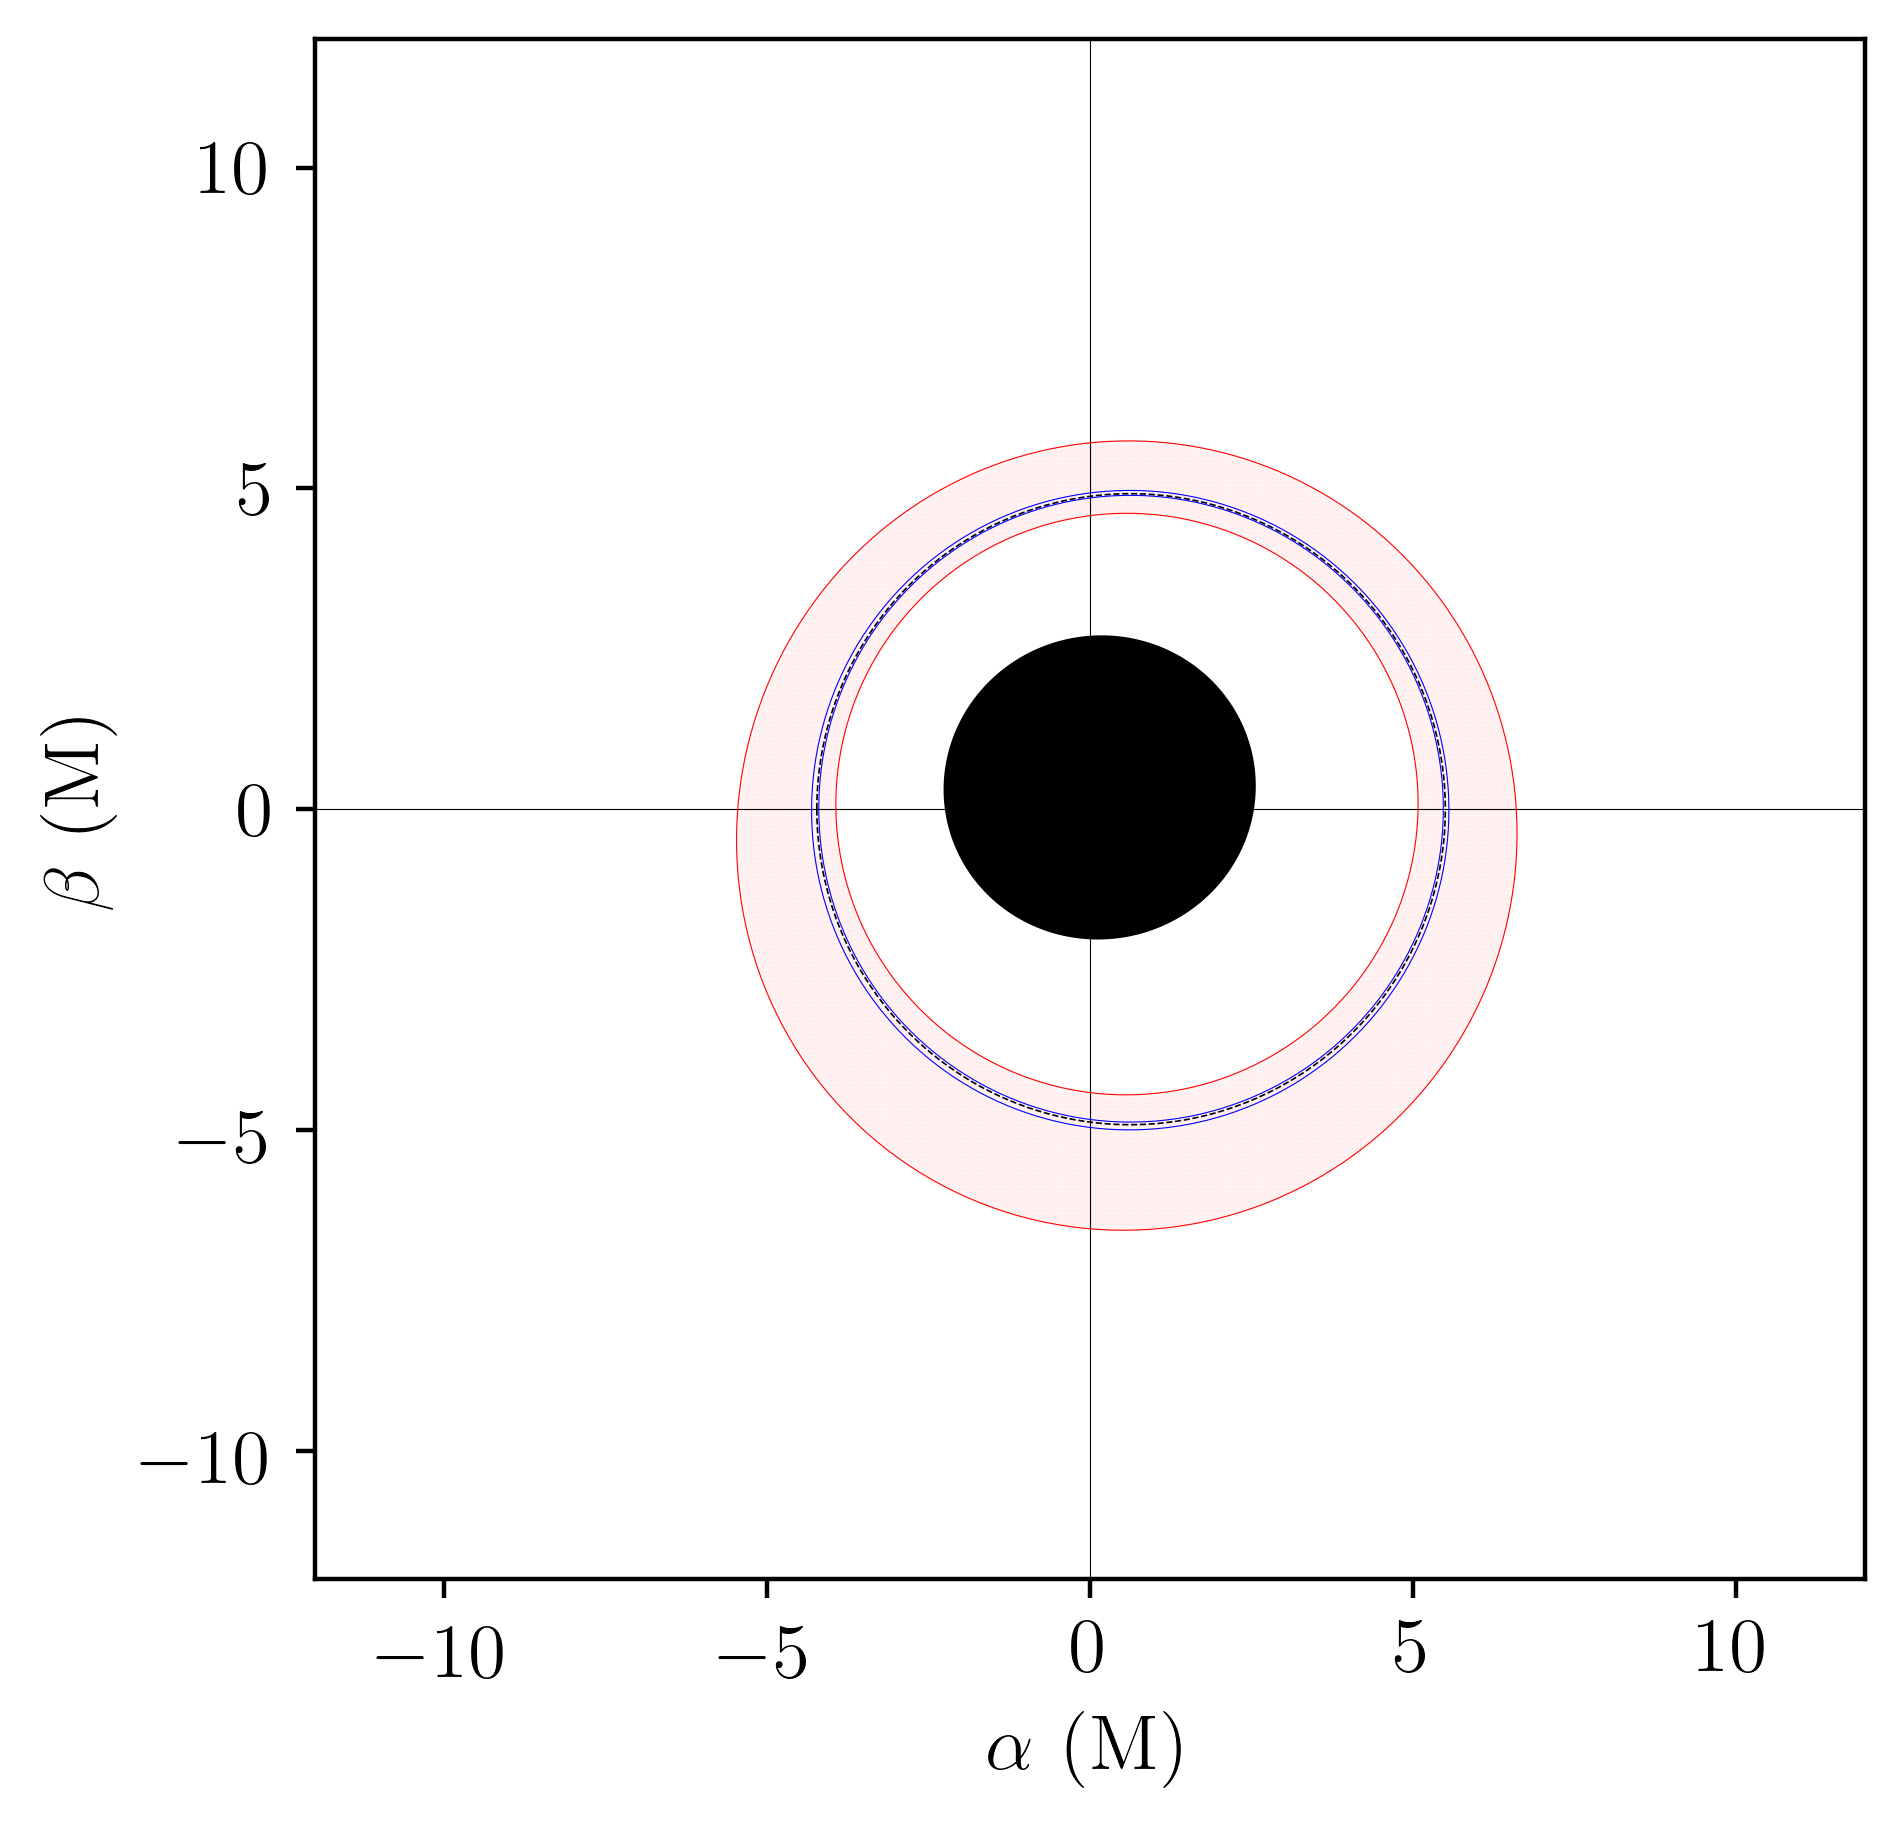

In [14]:
mkplot.lb(*profile, save_path=fig_path, **params)

## Analytical Ray-tracing

Now, for each pixel on each grid, let us compute where are they coming from, i.e., we ray-trace backwards in time into the geometry. 

In [15]:
%time rt.raytrace(**params)

Reading file:  Results/Raytracing/LensingBands_a_0.5_i_17_dx0_0.02_dx1_0.02_dx2_0.02.h5
Analytical ray-tracing of the n=0 band points
Analytical ray-tracing of the n=1 band points
Analytical ray-tracing of the n=2 band points
File  Results/Raytracing/Rays_a_0.5_i_17_bv_0.h5  created.

A total of 18750000 photons were ray-traced
Reading file:  Results/Raytracing/LensingBands_a_0.94_i_17_dx0_0.02_dx1_0.02_dx2_0.02.h5
Analytical ray-tracing of the n=0 band points
Analytical ray-tracing of the n=1 band points
Analytical ray-tracing of the n=2 band points
File  Results/Raytracing/Rays_a_0.94_i_17_bv_0.h5  created.

A total of 18750000 photons were ray-traced
CPU times: user 1min 59s, sys: 3.58 s, total: 2min 3s
Wall time: 2min 3s


## Plotting the $r$ and $\phi$ values of the $n=0$ band

We can now visualize how the coordinates of the direct image look on the observer's screen. In the background we plot contours of the polar coordinate (every $45$ degrees) and make some contours of constant Boyer-Lindquist radius $r_{\rm s}=3,6,9,12,15,20$. 

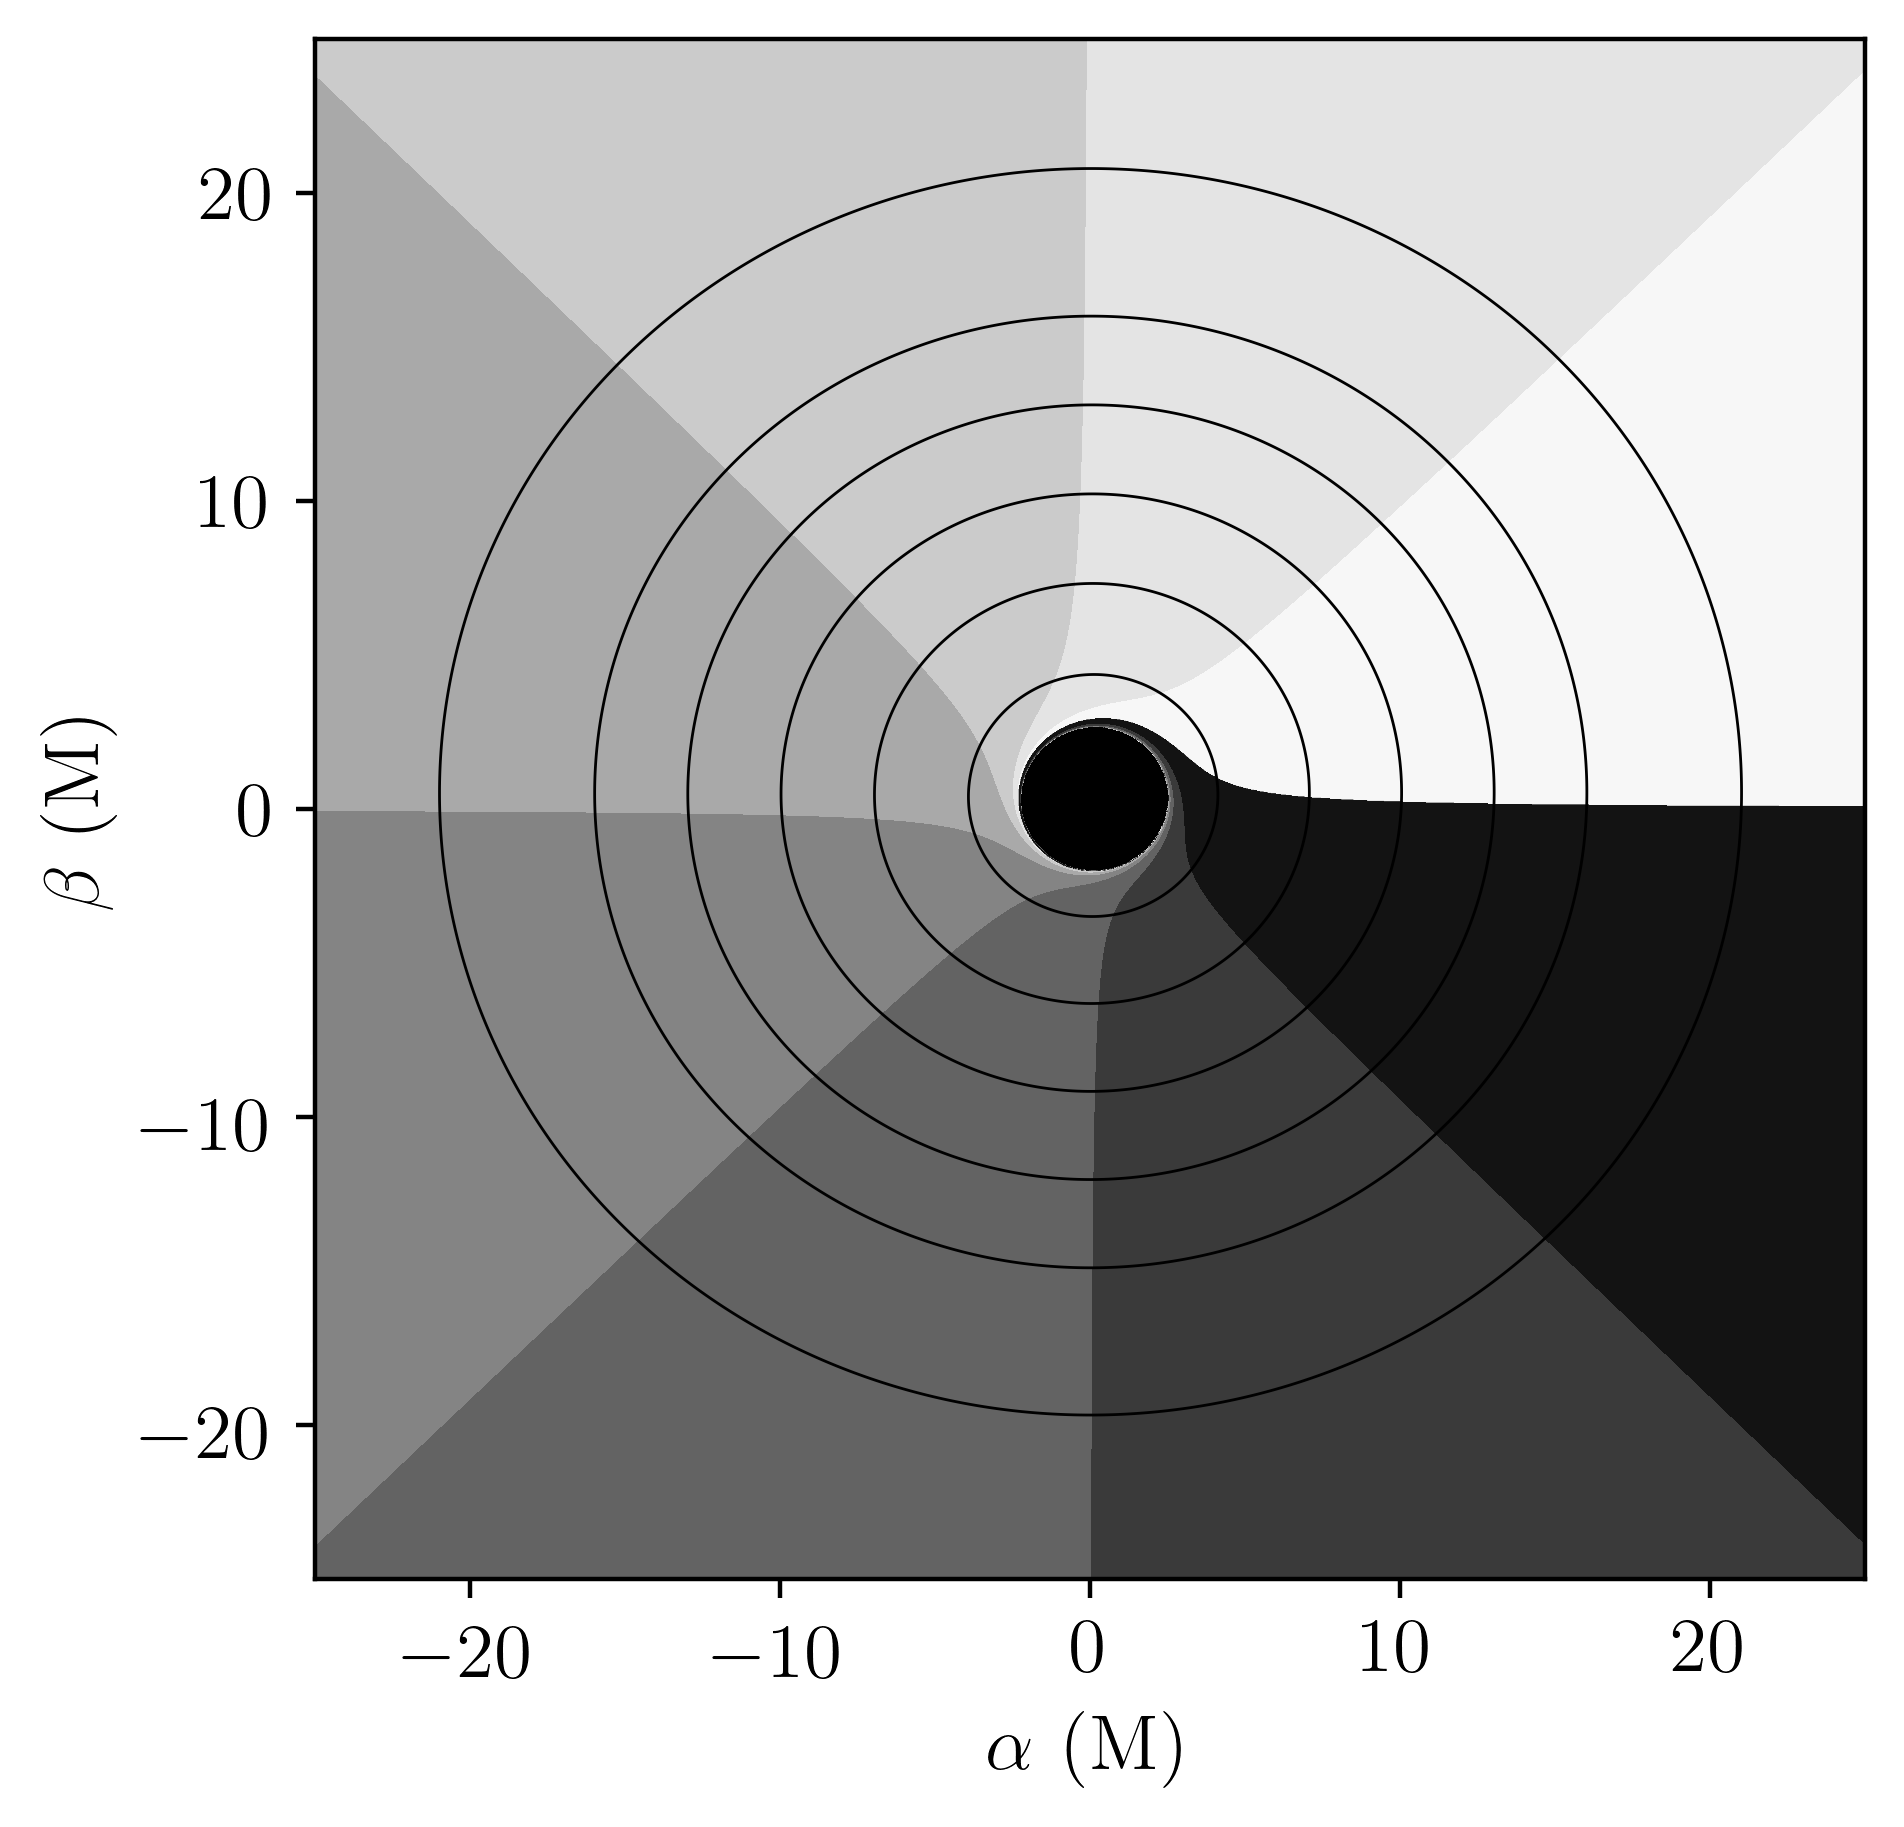

In [16]:
mkplot.directimage(*profile, save_path=fig_path, **params)

You can also plot the coordinate information of the other lensing bands. Note that all these figures are being saved in the folder specified above (`fig_path`). 

# Computing black hole images

Up to now, everything was purely geometrical, i.e., the calculation just depended on the spin and the inclination of the observer. Now, you can implemement your own illumination profile and compute observables. Whenever you change your astrophysics, you do not have to repeat the above calculations.

Let us compute some images assuming the Johnson's SU distribution,
\begin{align}
J_{\rm{SU}}(r;\mu,\vartheta,\gamma)\equiv\frac{e^{-\frac{1}{2} \left[ \gamma + \sinh^{-1} \left( \frac{r-\mu}{\vartheta} \right) \right]}}{\sqrt{\left(r-\mu \right)^2+\vartheta^2}},
\end{align}

for the effective emissitiviy of the disk. Recall that when specifying the parameters at the beginning of the notebook, for $\mu$ we used the inner horizon, i.e., $\mu=r_-$.

Now, let us compute the intensities:
\begin{align}
I_{\rm o}(\alpha,\beta)=\sum_{n=0}^{N(\alpha,\beta)-1}\zeta_n\cdot g^3\left(r_{\rm s}^{(n)},\alpha \right)I_{\rm s}\left(r^{(n)}_{\rm s}\right),
\end{align}

where $r_{\rm s}^{(n)}=r_{\rm s}^{(n)}(\alpha,\beta)$ denotes the (analytically known) equatorial radius at which a ray intersects the equatorial plane for the $(n+1)^\text{th}$ time on its backward trajectory from the image-plane position $(\alpha,\beta)$, up to a total number $N(\alpha,\beta)$ along its maximal extension.

In [17]:
%time ri.cintensity(**params)  ## compute radial intensity observables

Reading file:  Results/Raytracing/LensingBands_a_0.5_i_17_dx0_0.02_dx1_0.02_dx2_0.02.h5
Reading file:  Results/Raytracing/Rays_a_0.5_i_17_bv_0.h5
File  Results/Raytracing/Intensity_a_0.5_i_17_sk_1.1_bphi_1.1_br_1.1_bvapp_0_gfact_3_gp_-0.5_sp_1.h5  created.
Reading file:  Results/Raytracing/LensingBands_a_0.94_i_17_dx0_0.02_dx1_0.02_dx2_0.02.h5
Reading file:  Results/Raytracing/Rays_a_0.94_i_17_bv_0.h5
File  Results/Raytracing/Intensity_a_0.94_i_17_sk_1.0_bphi_1.0_br_1.0_bvapp_0_gfact_3_gp_-1.5_sp_0.5.h5  created.
CPU times: user 1.1 s, sys: 292 ms, total: 1.39 s
Wall time: 1.39 s


And now we can plot the results. Note that the fudge factor was used to enhance the $n=1$ and $n=2$ intensities in the function `ri.cintensity`, so if one wants to change the fudge then _params_ needs to be redefined and `ri.cintensity` run again accordingly.

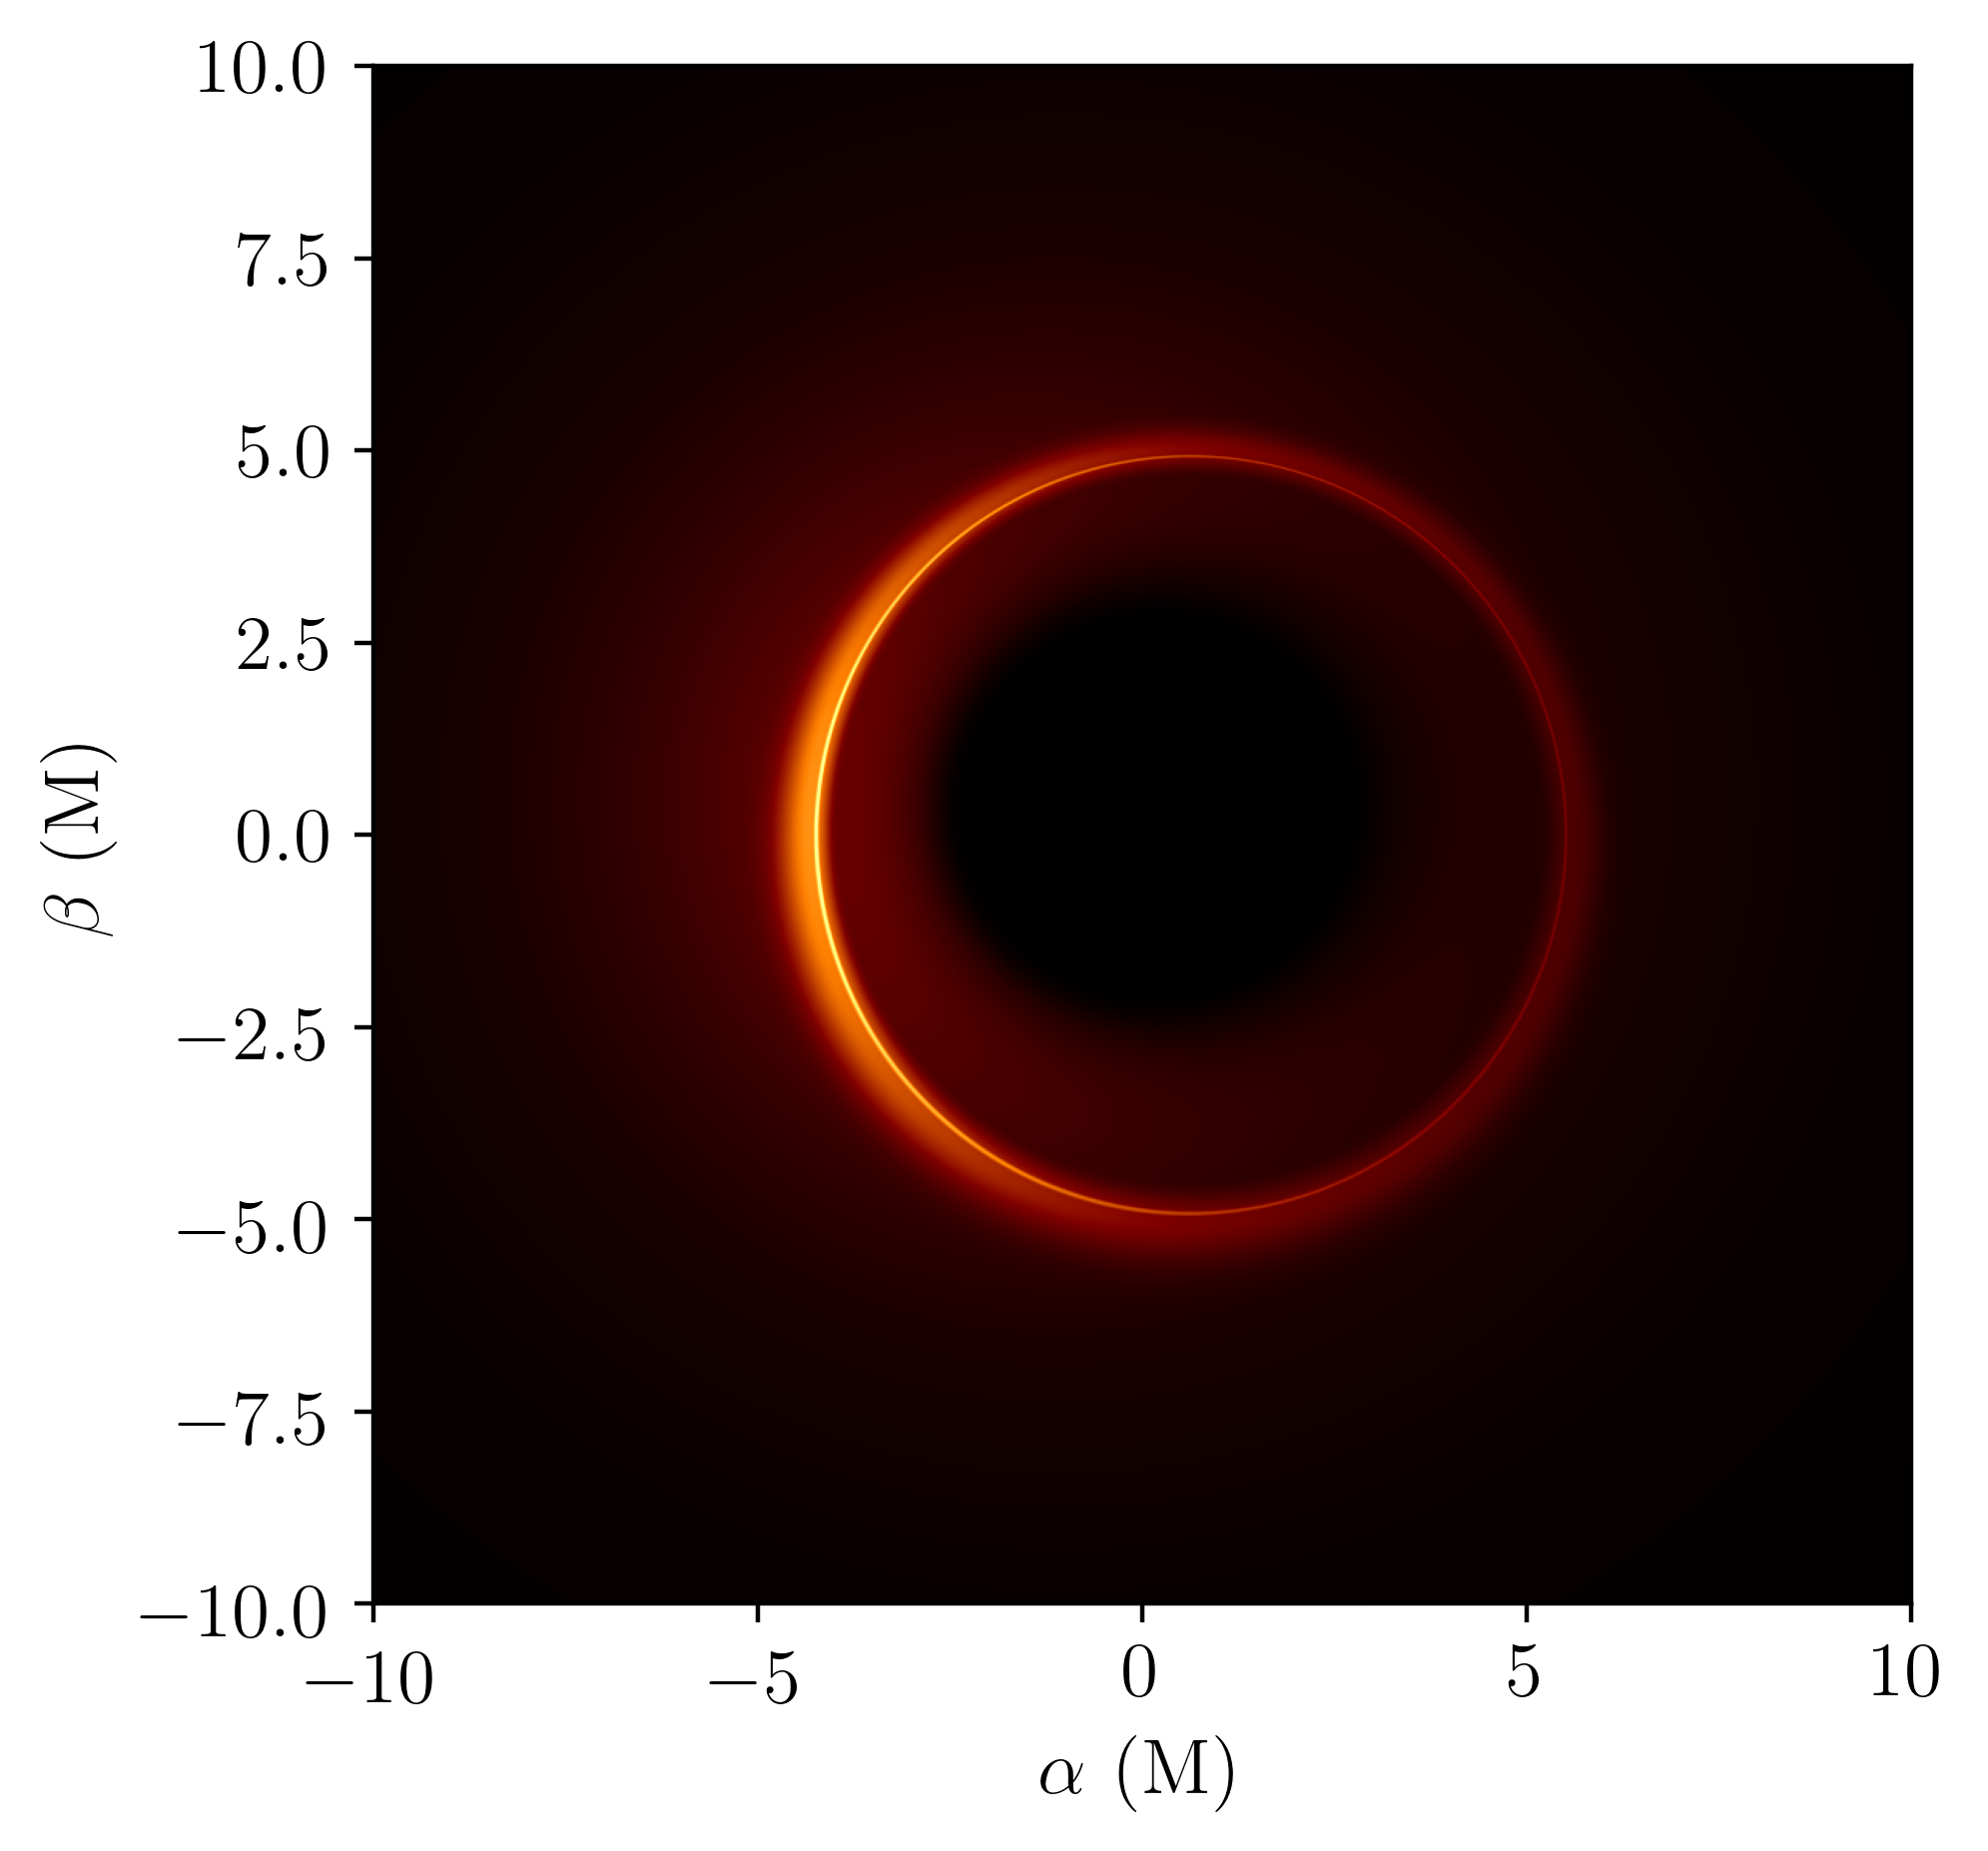

In [18]:
mkplot.bhimage(*profile, save_path=fig_path, **params)

This image looks like a time-averaged GRMHD simulation! 

# Computing the visibility amplitude

Let us now compute the visibility amplitude for several baselines, as specified by _radonangles_ in _params_. Here we will compute 36 cuts, as we will later fit them to a circlipse. 

In [19]:
%time va.cvisamp(**params)

Reading file:  Results/Raytracing/LensingBands_a_0.5_i_17_dx0_0.02_dx1_0.02_dx2_0.02.h5
Reading file:  Results/Raytracing/Intensity_a_0.5_i_17_sk_1.1_bphi_1.1_br_1.1_bvapp_0_gfact_3_gp_-0.5_sp_1.h5
File  Results/Raytracing/Visamp_0_a_0.5_i_17_dx0_0.02_dx1_0.02_dx2_0.02_sk_1.1_bphi_1.1_br_1.1_bvapp_0_gfact_3_gp_-0.5_sp_1_fudge_1.0_Ncut_0.h5  created.
File  Results/Raytracing/Visamp_5_a_0.5_i_17_dx0_0.02_dx1_0.02_dx2_0.02_sk_1.1_bphi_1.1_br_1.1_bvapp_0_gfact_3_gp_-0.5_sp_1_fudge_1.0_Ncut_0.h5  created.
File  Results/Raytracing/Visamp_10_a_0.5_i_17_dx0_0.02_dx1_0.02_dx2_0.02_sk_1.1_bphi_1.1_br_1.1_bvapp_0_gfact_3_gp_-0.5_sp_1_fudge_1.0_Ncut_0.h5  created.
File  Results/Raytracing/Visamp_15_a_0.5_i_17_dx0_0.02_dx1_0.02_dx2_0.02_sk_1.1_bphi_1.1_br_1.1_bvapp_0_gfact_3_gp_-0.5_sp_1_fudge_1.0_Ncut_0.h5  created.
File  Results/Raytracing/Visamp_20_a_0.5_i_17_dx0_0.02_dx1_0.02_dx2_0.02_sk_1.1_bphi_1.1_br_1.1_bvapp_0_gfact_3_gp_-0.5_sp_1_fudge_1.0_Ncut_0.h5  created.
File  Results/Raytracing/Visa

File  Results/Raytracing/Visamp_70_a_0.94_i_17_dx0_0.02_dx1_0.02_dx2_0.02_sk_1.0_bphi_1.0_br_1.0_bvapp_0_gfact_3_gp_-1.5_sp_0.5_fudge_1.5_Ncut_0.h5  created.
File  Results/Raytracing/Visamp_75_a_0.94_i_17_dx0_0.02_dx1_0.02_dx2_0.02_sk_1.0_bphi_1.0_br_1.0_bvapp_0_gfact_3_gp_-1.5_sp_0.5_fudge_1.5_Ncut_0.h5  created.
File  Results/Raytracing/Visamp_80_a_0.94_i_17_dx0_0.02_dx1_0.02_dx2_0.02_sk_1.0_bphi_1.0_br_1.0_bvapp_0_gfact_3_gp_-1.5_sp_0.5_fudge_1.5_Ncut_0.h5  created.
File  Results/Raytracing/Visamp_85_a_0.94_i_17_dx0_0.02_dx1_0.02_dx2_0.02_sk_1.0_bphi_1.0_br_1.0_bvapp_0_gfact_3_gp_-1.5_sp_0.5_fudge_1.5_Ncut_0.h5  created.
File  Results/Raytracing/Visamp_90_a_0.94_i_17_dx0_0.02_dx1_0.02_dx2_0.02_sk_1.0_bphi_1.0_br_1.0_bvapp_0_gfact_3_gp_-1.5_sp_0.5_fudge_1.5_Ncut_0.h5  created.
File  Results/Raytracing/Visamp_95_a_0.94_i_17_dx0_0.02_dx1_0.02_dx2_0.02_sk_1.0_bphi_1.0_br_1.0_bvapp_0_gfact_3_gp_-1.5_sp_0.5_fudge_1.5_Ncut_0.h5  created.
File  Results/Raytracing/Visamp_100_a_0.94_i_17_dx0_

### Plotting the visibility amplitudes

Let us inspect only two cuts, i.e., horizontal and vertical. Note that the iterable object _radonangles_plot_ below need not be the same as _radonangles_ in _params_. In `mkplot.vispolot` you can specify the baseline angles for which you would like to plot the visibility amplitude.

In [20]:
radonangles_plot=[0,90]

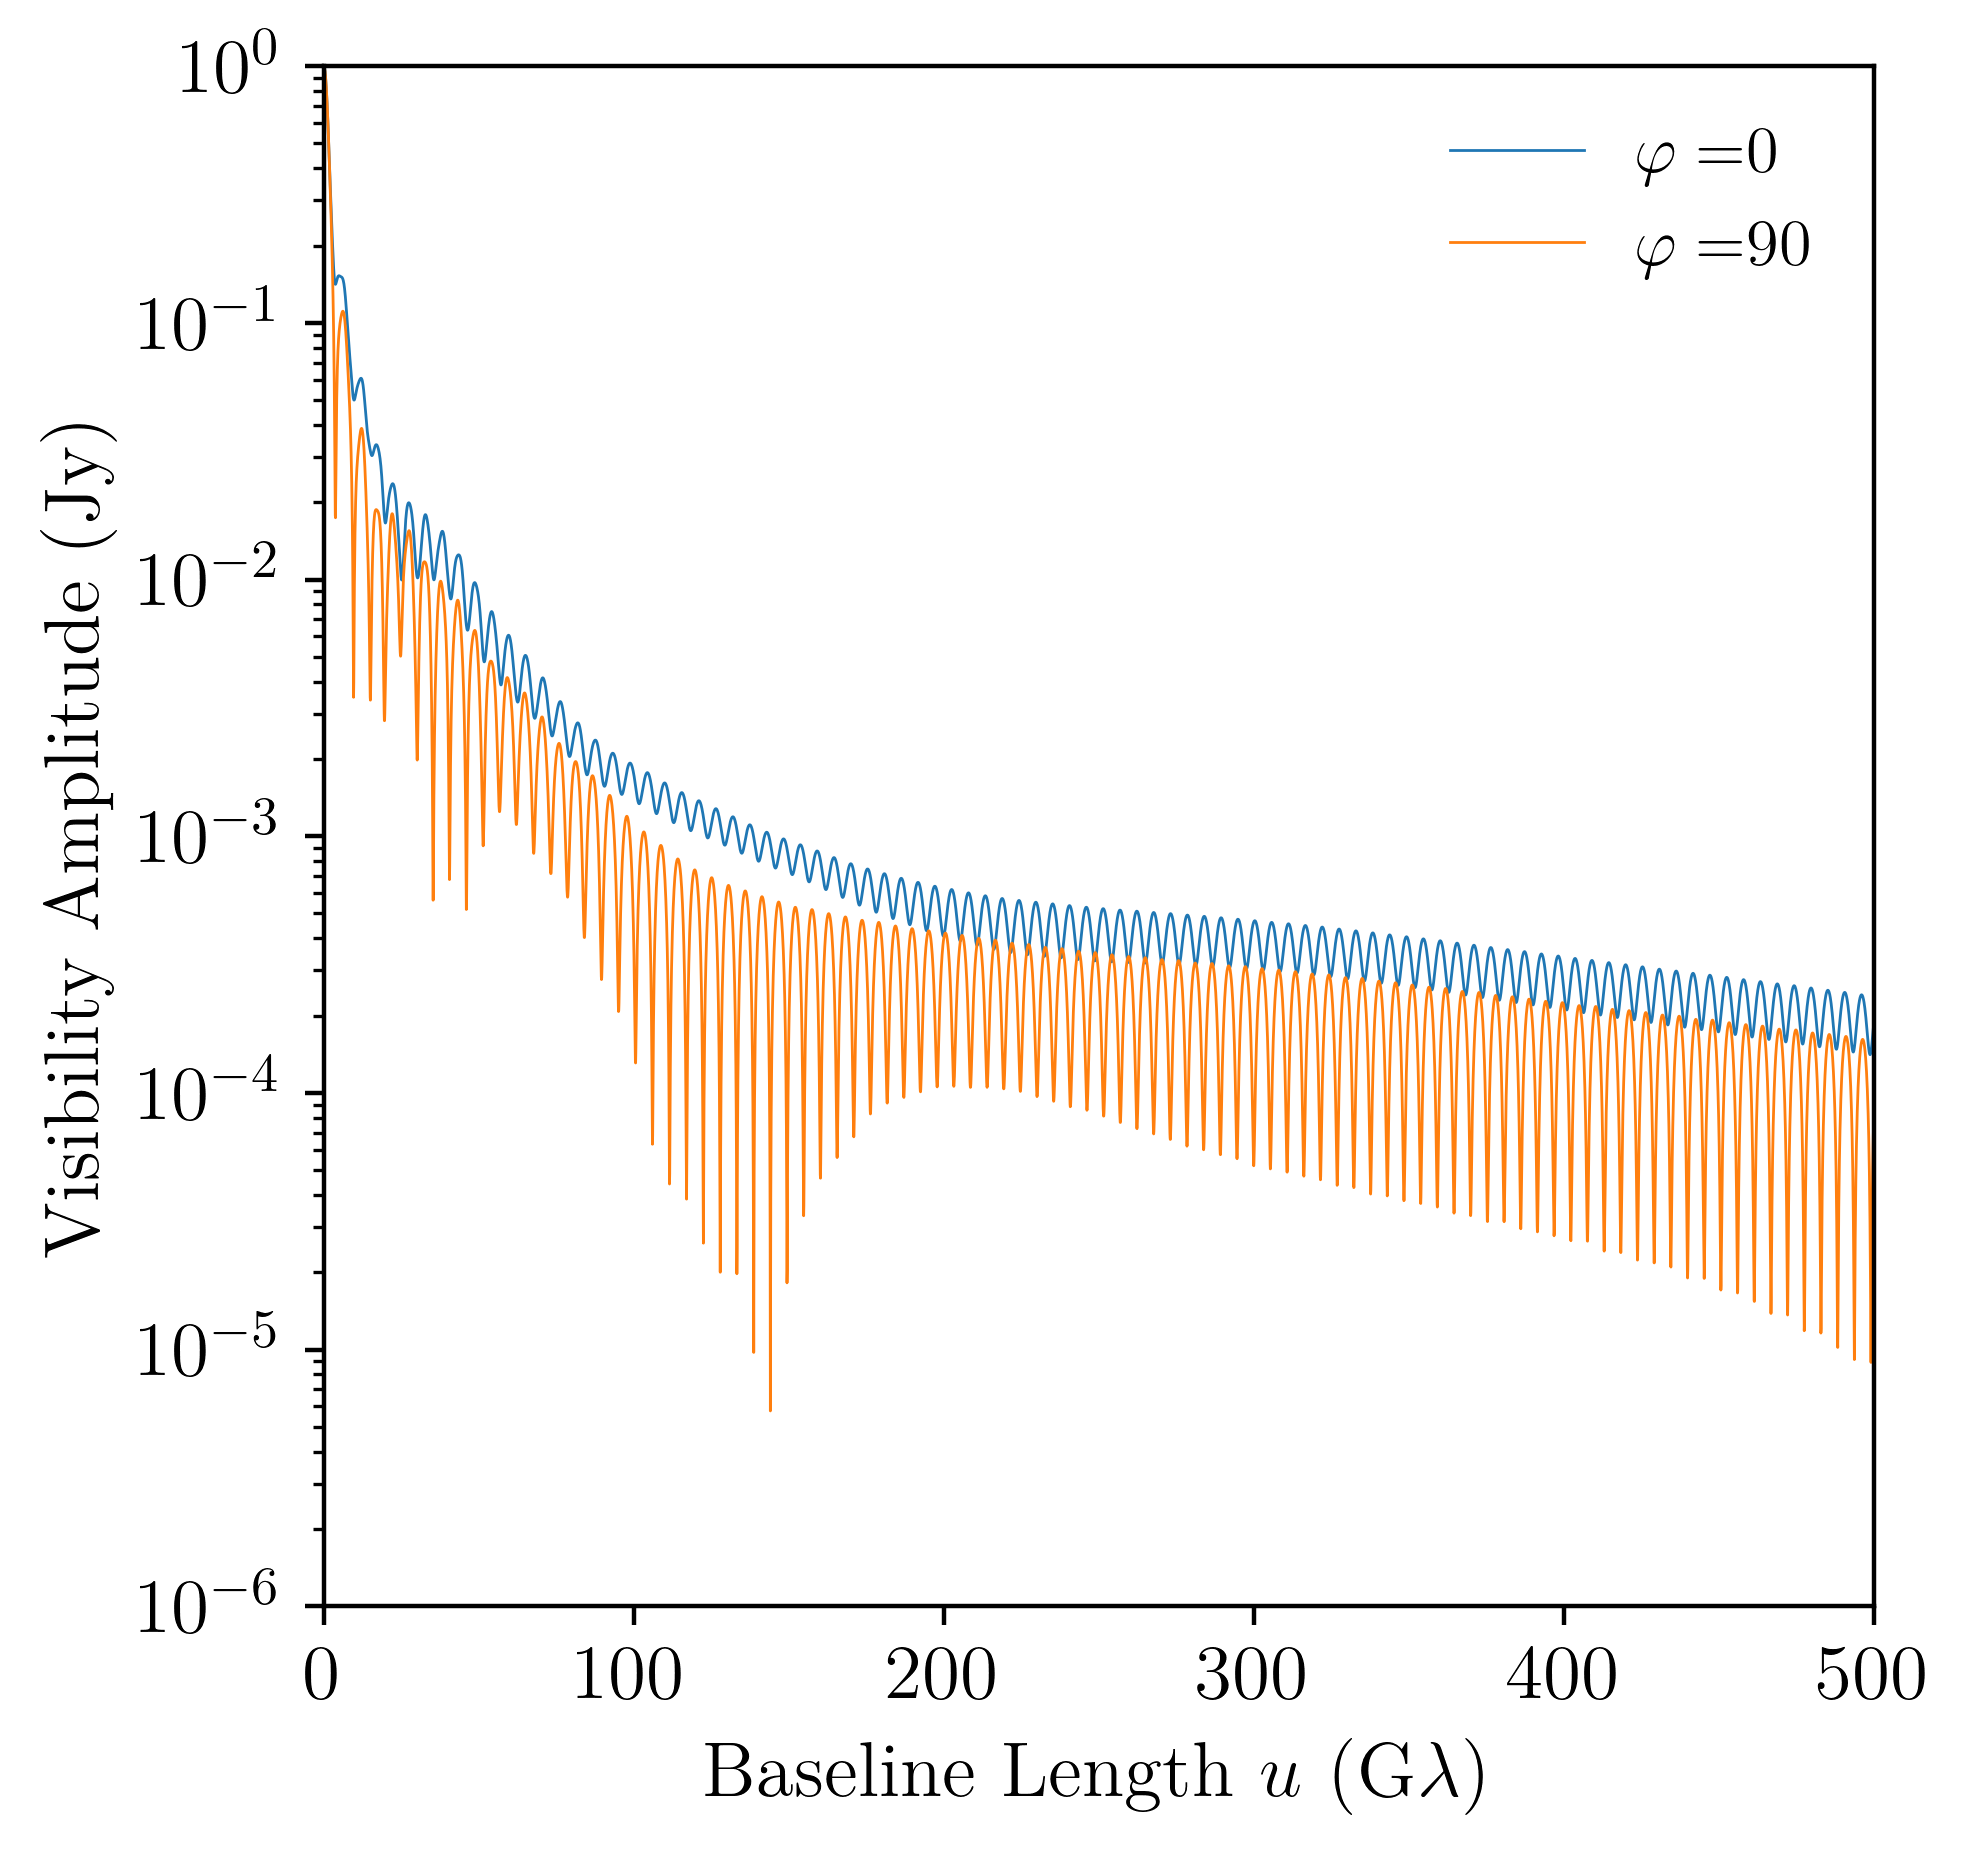

In [21]:
mkplot.visplot(*profile, rangles=radonangles_plot, save_path=fig_path, **params) 

Note that for this example we have made the grids to coincide by setting `p_image=1` in _params_. However, it is more efficient to compute each lensing band with different resolutions. As such, it would be better change the following parameters in _params_ to

- p_image=0
- limits=25
- dx0 =0.05
- dx1 =0.02
- dx2 =0.01
    
If you do that, you will have to re-compute the lensing bands, rays and the intensities.

# Using <em>AART</em> with an <em>inoisy </em> simulation

### Exploring the <em>inoisy </em> file

This example uses a precomputed (<em>very low resolution!</em>) inoisy dataset in the form of a file named "inoisy.h5" saved in the same directory in the notebook. Details can be found in:

- https://github.com/AFD-Illinois/inoisy
- Lee, D., & Gammie, C. F. (2021). Disks as inhomogeneous, anisotropic gaussian random fields. The Astrophysical Journal, 906(1), 39.

We first plot the source profile image.

There are 256 snapshots in this inoisy data set
Each one has a 128 x 128 size


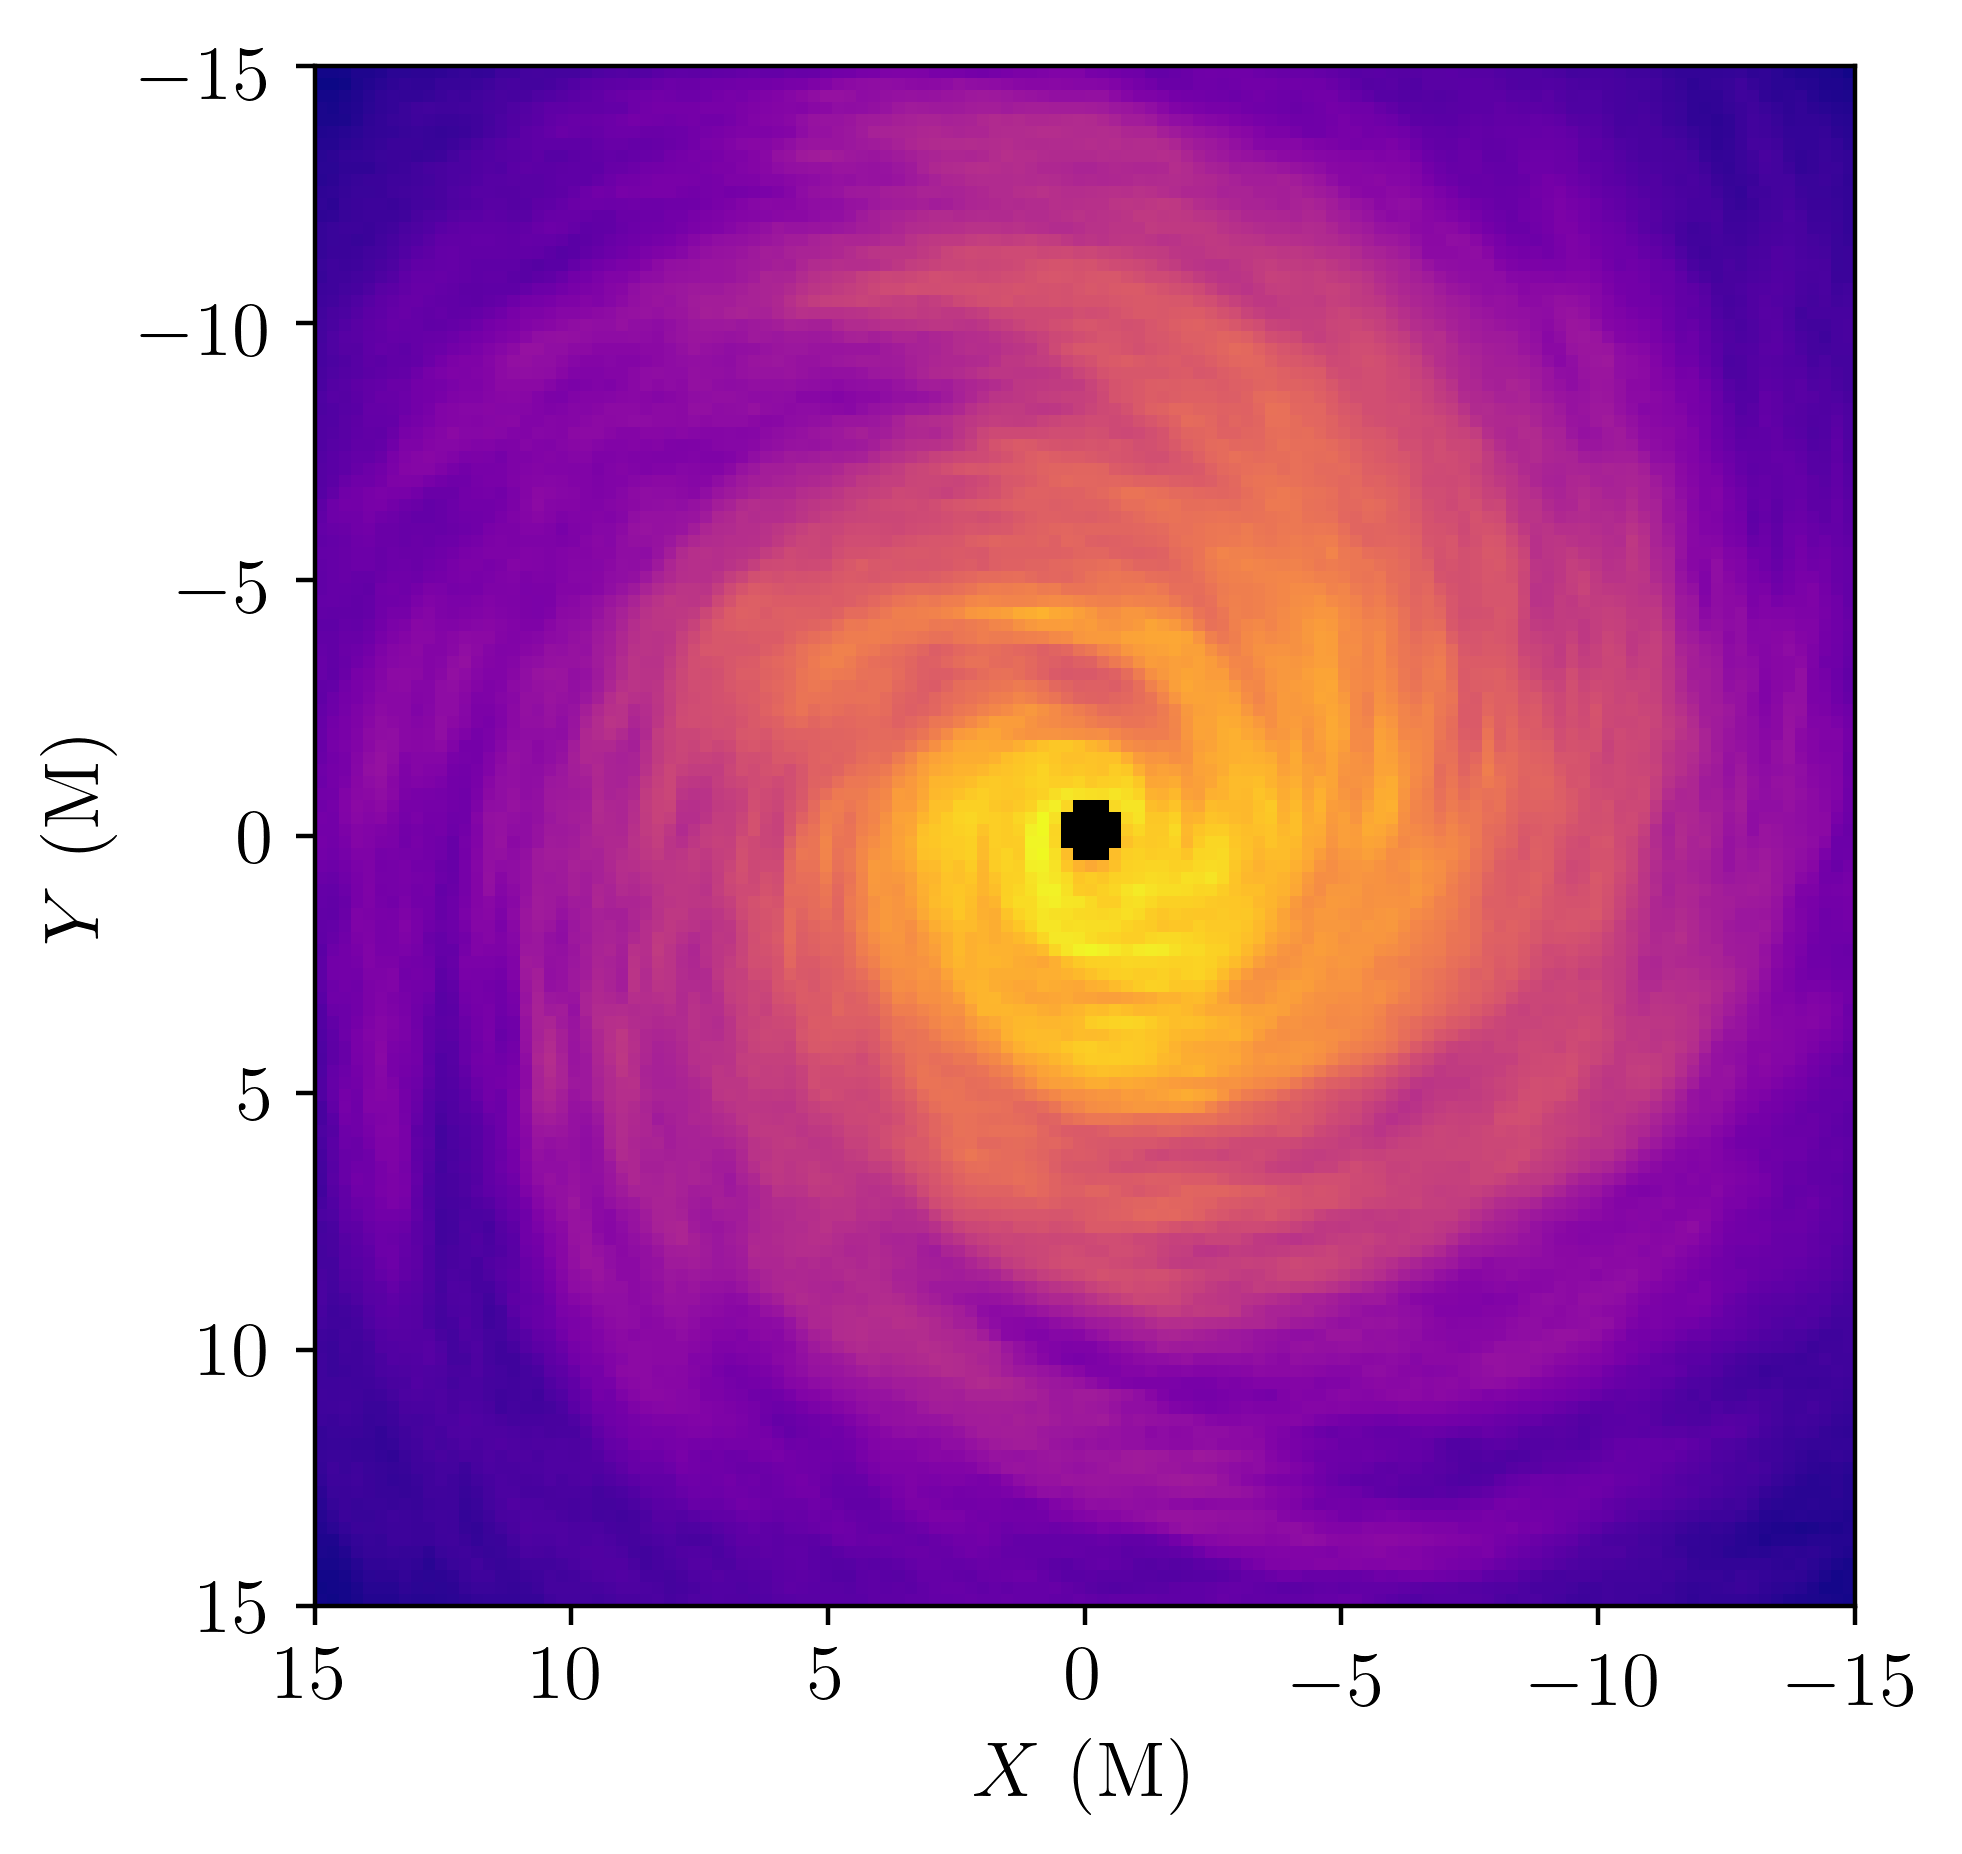

In [22]:
mkplot.sourceprofile()

### Single ray-traced image

Let us now ray-trace this (very low-resolution) equatorial profile.

In [23]:
im.image(**params)

Reading file:  Results/Raytracing/LensingBands_a_0.5_i_17_dx0_0.02_dx1_0.02_dx2_0.02.h5
Reading file:  Results/Raytracing/Rays_a_0.5_i_17_bv_0.h5
Reading inoisy file:  inoisy.h5
AART starts!
Using all the available inoisy frames
Computing lensed image using all inoisy frames
Images file  Results/Raytracing/Dynamical_Image_a_0.5_i_17_bv_0_bphi_1.1_br_1.1_gfact_3_sk_1.1_itM_0.h5  created.
Reading file:  Results/Raytracing/LensingBands_a_0.94_i_17_dx0_0.02_dx1_0.02_dx2_0.02.h5
Reading file:  Results/Raytracing/Rays_a_0.94_i_17_bv_0.h5
Reading inoisy file:  inoisy.h5
AART starts!
Using all the available inoisy frames
Computing lensed image using all inoisy frames
Images file  Results/Raytracing/Dynamical_Image_a_0.94_i_17_bv_0_bphi_1.0_br_1.0_gfact_3_sk_1.0_itM_0.h5  created.


Reading file:  Results/Raytracing/Dynamical_Image_a_0.94_i_17_bv_0_bphi_1.0_br_1.0_gfact_3_sk_1.0_itM_0.h5


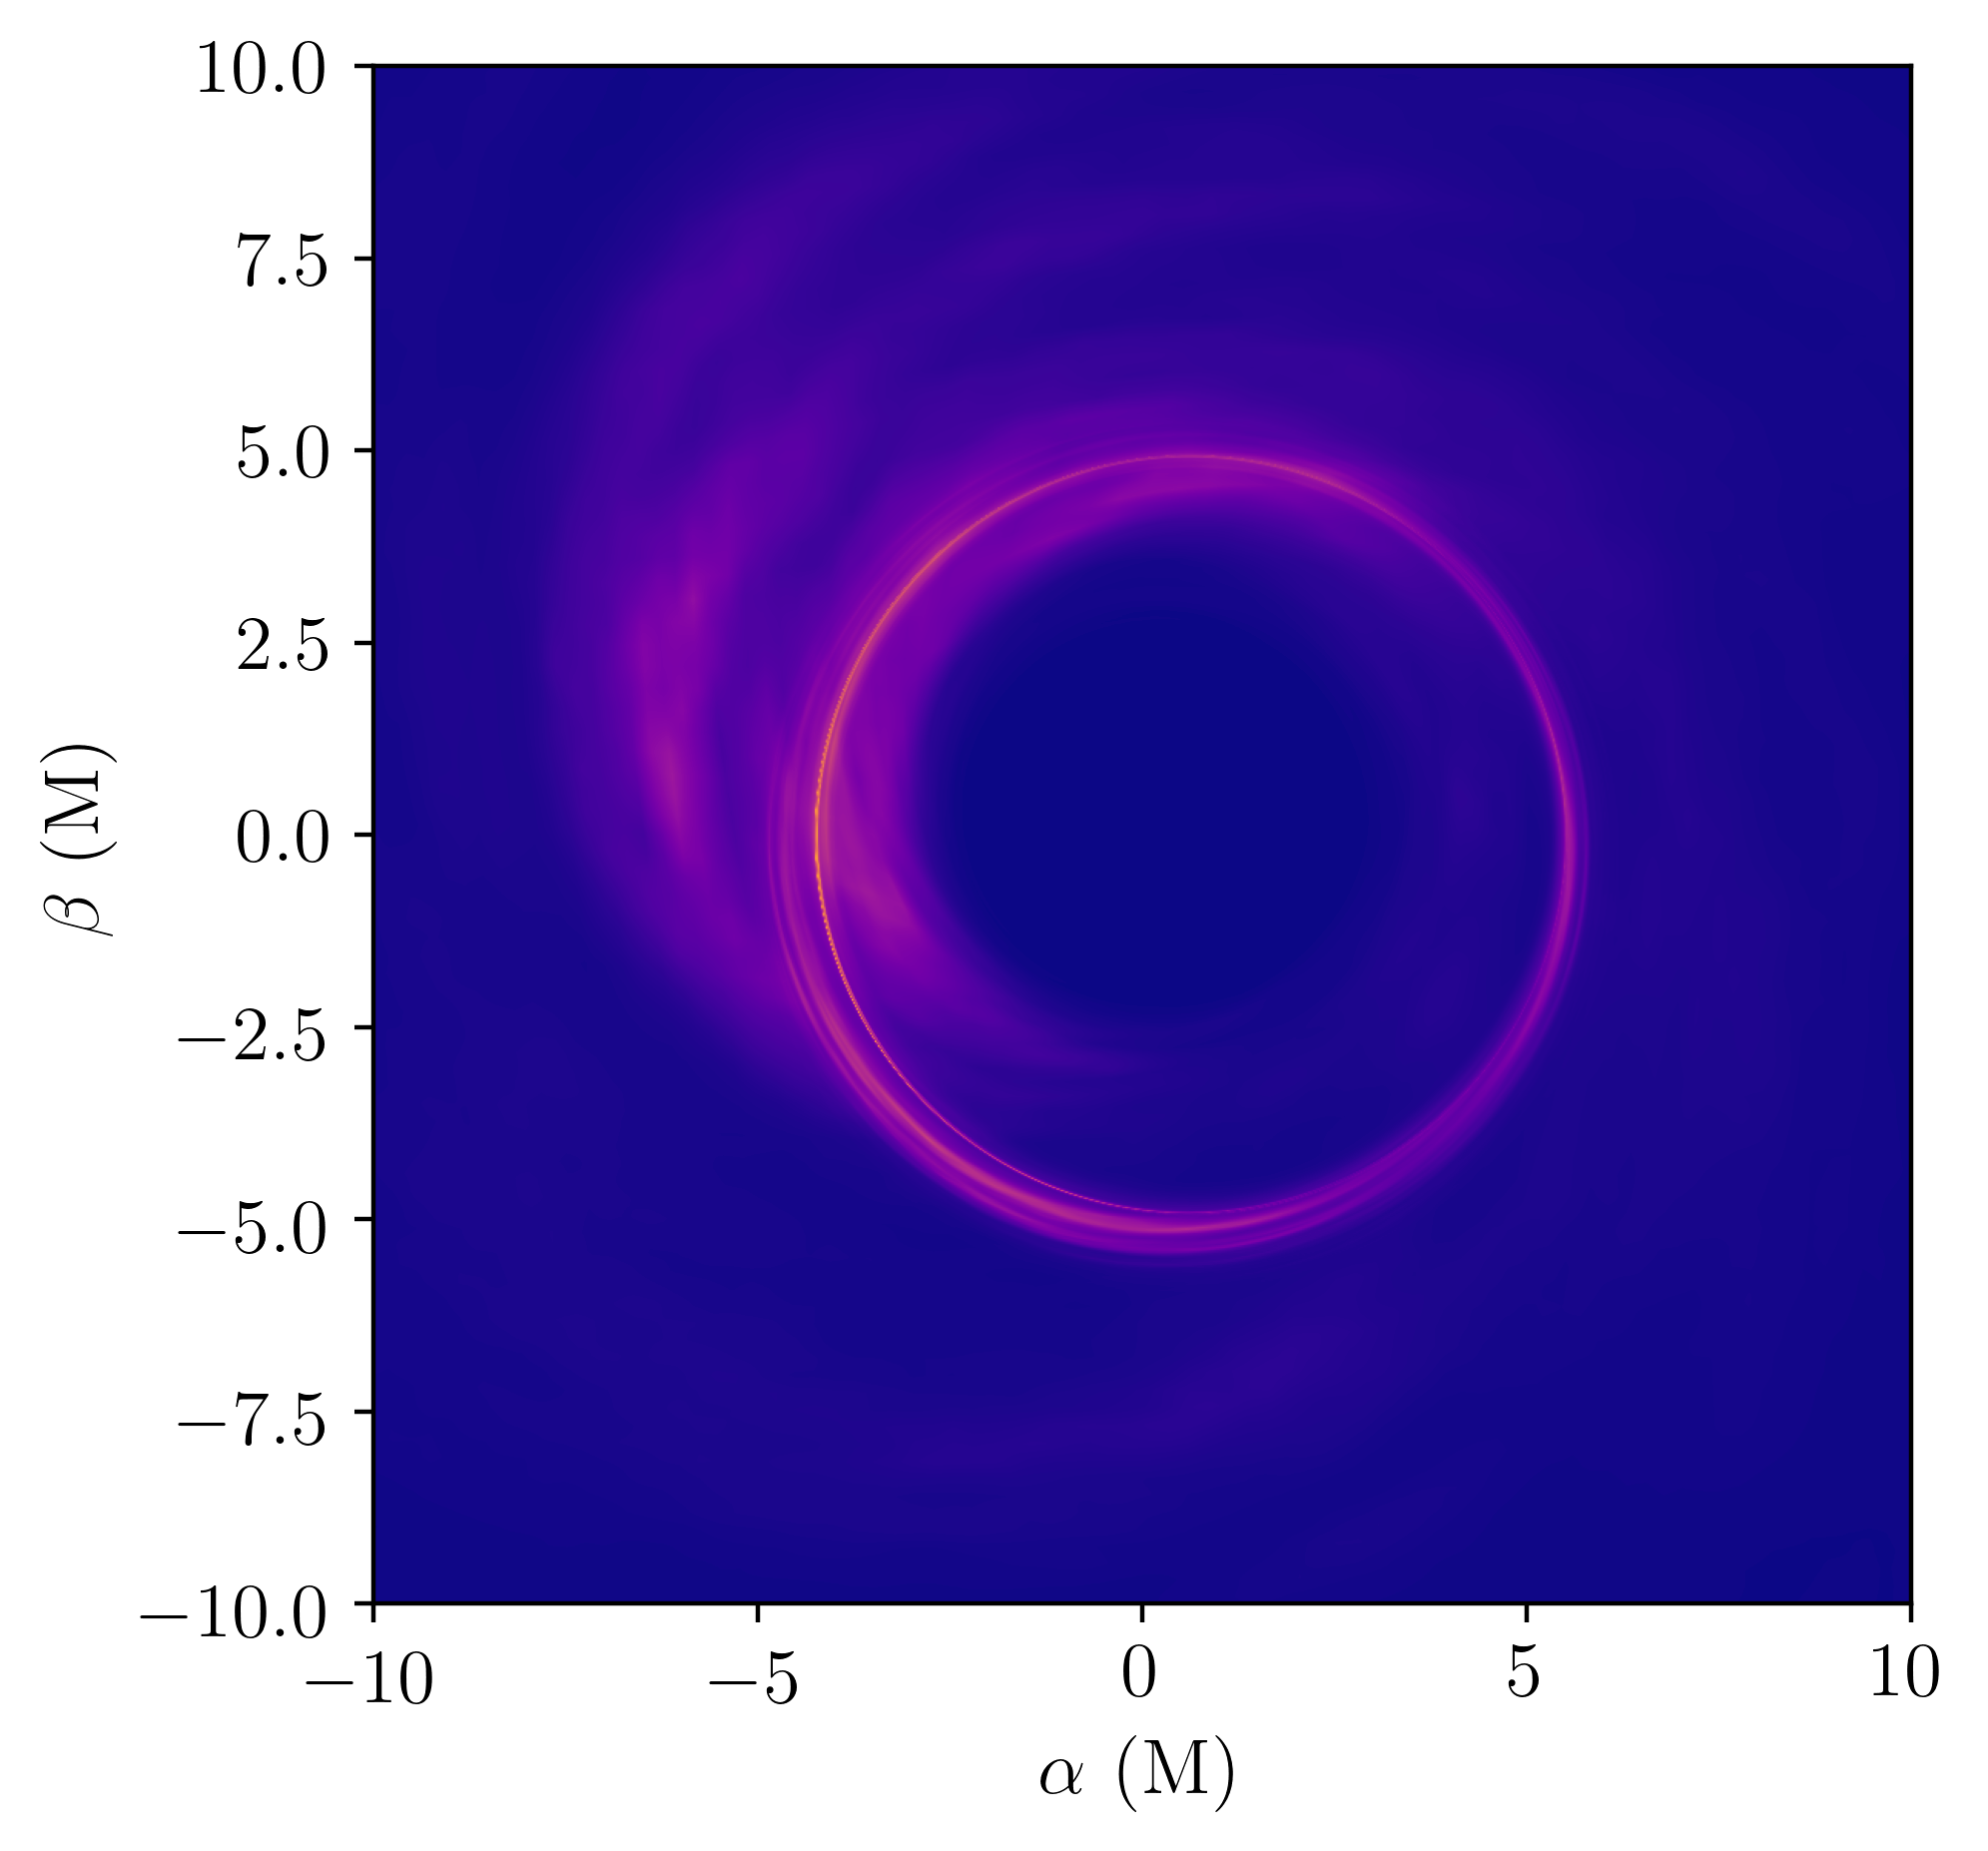

<Figure size 640x480 with 0 Axes>

In [24]:
mkplot.dynamicalimage(*profile, save_path=fig_path, **params)

### Movies

Let us now compute _snapshots=12_ successive images, which will then be compiled together to form a gif using `mkplot.movie`. 

In [25]:
imov.movie(**params)

Movies
Reading file:  Results/Raytracing/LensingBands_a_0.5_i_17_dx0_0.02_dx1_0.02_dx2_0.02.h5
Reading file:  Results/Raytracing/Rays_a_0.5_i_17_bv_0.h5
Reading inoisy file:  inoisy.h5
AART starts!
Calculating an image at time t=0.0 (M)
Calculating an image at time t=1.09091 (M)
Calculating an image at time t=2.18182 (M)
Calculating an image at time t=3.27273 (M)
Calculating an image at time t=4.36364 (M)
Calculating an image at time t=5.45455 (M)
Calculating an image at time t=6.54545 (M)
Calculating an image at time t=7.63636 (M)
Calculating an image at time t=8.72727 (M)
Calculating an image at time t=9.81818 (M)
Calculating an image at time t=10.90909 (M)
Calculating an image at time t=12.0 (M)
Images  Results/Raytracing/Images_a_0.5_i_17_bv_0_bphi_1.1_br_1.1_gfact_3_sk_1.1_itM_0_ftM_12_shots_12.h5  created.

Movies
Reading file:  Results/Raytracing/LensingBands_a_0.94_i_17_dx0_0.02_dx1_0.02_dx2_0.02.h5
Reading file:  Results/Raytracing/Rays_a_0.94_i_17_bv_0.h5
Reading inoisy file:

In [26]:
mkplot.movie(*profile, save_path=fig_path, **params)

Reading file:  Results/Raytracing/Images_a_0.94_i_17_bv_0_bphi_1.0_br_1.0_gfact_3_sk_1.0_itM_0_ftM_12_shots_12.h5


The number of snapshots in the gif produced by mkplot.movie is specified in _params_. The following is the resulting gif with the default value of 12 snapshots (this gif may not be visible from the github page):

Note that the gif is named accordingly:

```
spin_case=params.get('spins')[mask1]
i_case=params.get('i_angles')[mask2]
betaphi=params.get('betaphi')[mask1]
betar=params.get('betar')[mask1]
gfactor=params.get('gfactor')
sub_kep=params.get('sub_kep')[mask1]

gif='BHMovie_a_%s_i_%s_bphi_%s_br_%s_sk_%s_gfact_%s.gif'%(spin_case, i_case, betaphi, betar, sub_kep, gfactor)
```

<img src="BHMovie_a_0.94_i_17_bphi_1.0_br_1.0_sk_1.0_gfact_3.gif?raw=true" width="400" align="center">

# Calcuting the diameters of the $n=2$ photon ring

Now we turn our attention to analyzing the $n=2$ photon ring. In this section we take the visibility amplitude simulated earlier in the notebook and extract from it the so-called parallel and perpendicular diameters of the $n=2$ photon ring. The extracting of these diameters is packaged in the function `aart.radialfit.radialfit`.

In [27]:
from aart import radialfit as rf

We first extract the visibility amplitude data. Note that _params_ is taken as argument in the functions called in the following cell only because we are taking as the visibility profile that which was produced by the simulations in the previous sections. Nowhere else in the rest of the notebook is the object _params_ explicitly used. That is, our fitting method is not dependent on the parameters of the BH, because the ultimate objective is to determine (some of) these. As such, one can input a visibility profile (and its corresponding frequencies) whose underlying profile is unknown to the `radialfit` function.

In [28]:
visamps=rf.get_visamps(*profile, **params)
freqs=rf.get_freqs(*profile, **params)

We now perform our fitting technique over the narrow baseline window [285, 315]G$\lambda$. Note that in this example we ignore the effects of noise, hence the arguments `s_n` and `mu_n`, the standard deviation and mean of a gaussian distributed noise profile, are set to zero.

In [29]:
ulim1_fit=285
ulim2_fit=315
mu_n=0
s_n=0.0
gfit_min=0.1
p0_ratio=0.11

In [30]:
%time rf.radialfit(visamps, freqs,radonangles, mu_n, s_n, ulim1_fit, ulim2_fit, gfit_min, fit_path, p0_ratio)

CPU times: user 2.07 s, sys: 15.8 ms, total: 2.09 s
Wall time: 2.09 s


A parameter of note here is `p0_ratio`$\in(0,1)$. This parameter determines the intial guess, p0, that curve_fit uses to find the best-fit values of $\alpha_\varphi^{L/R}$. More specifically, for each baseline angle $\varphi$ we use the visibility profile along that baseline to calculate the best-fit diameter $d_\varphi$ and the constants $\alpha_\varphi^{L/R}$ for the functional form of the visibility profile

\begin{align}
    V_\text{fit}(u;d)&=\frac{1}{\sqrt{u}}\sqrt{(\alpha^{L}_\varphi)^{2}+(\alpha^{R}_{\varphi})^{2}+2\alpha_{\varphi}^{L}\alpha_{\varphi}^{R}\sin{(2\pi d_\varphi u)}}.
\end{align}

In the code we determine approximate bounds on the parameters $\alpha_\varphi^{L/R}$, denoted by $\alpha^{L/R}_\text{max}$. Then, for each $\alpha^{L/R}_\varphi$, the curve_fit intial guess $p_0=[\alpha^{L}_\text{max}\times\text{p0_ratio}$, $\alpha^{R}_\text{max}\times\text{p0_ratio}$].

Having used this fitting method for various BH profiles, we unsurprisingly found that in some cases different values of `p0_ratio` can be "better" than others, particularly in the presence of non-zero noise. Scipy's curve_fit can sometimes get stuck in local minima and, as such, it's important to be able to slightly alter the value of our initial guess, e.g. from 0.10 to 0.11, so that we can be sure whether a suboptimal fit is a limitation of the method itself, or whether we are simply getting stuck in a local minimum. Further, sometimes it's necessary to vary `p0_ratio` by a more significant amount, e.g., from 0.10 to 0.80, because this would generate better fits and/or fits that fail less frequently. We strongly recommend performing several fits, e.g., $n=50$, with different `p0_ratio` values across the range $(0, 1)$ and recording the RMSD and rate of failure to gain an insight into which values of `p0_ratio` generate the "best" fits for some given visibility profile.

We now look at the data produced by `rf.radialfit`.

In [31]:
npz_s_0=np.load(fit_path+"Fit_%s_%s_gfit_%s_mun_%s_sn_%s.npz"%(ulim1_fit,ulim2_fit, gfit_min, mu_n, s_n), allow_pickle=True)

In [32]:
observables_s_0=npz_s_0['observables']

In extracting the diameters $d_{||}$ and $d_{\perp}$ from the visibility profile, `rf.radialfit` computes the best fit diameter $d_\varphi$ across the 36 baseline angles in `radonangles=np.arange(0, 180, 5)`. However, because each $d_\varphi$  is only a local minimum of the RMSD (root mean squared deviation), there exists a degeneracy such that the best fit diameter may not correspond to the 'true' ring diameter. As such, for each best fit diameter $d_\varphi$, we consider other diameters in the range [8M, 12M] that are peaks of the goodness of fit as candidates for the 'true' diameter. This leads to the plot generated by the code in the cell below.

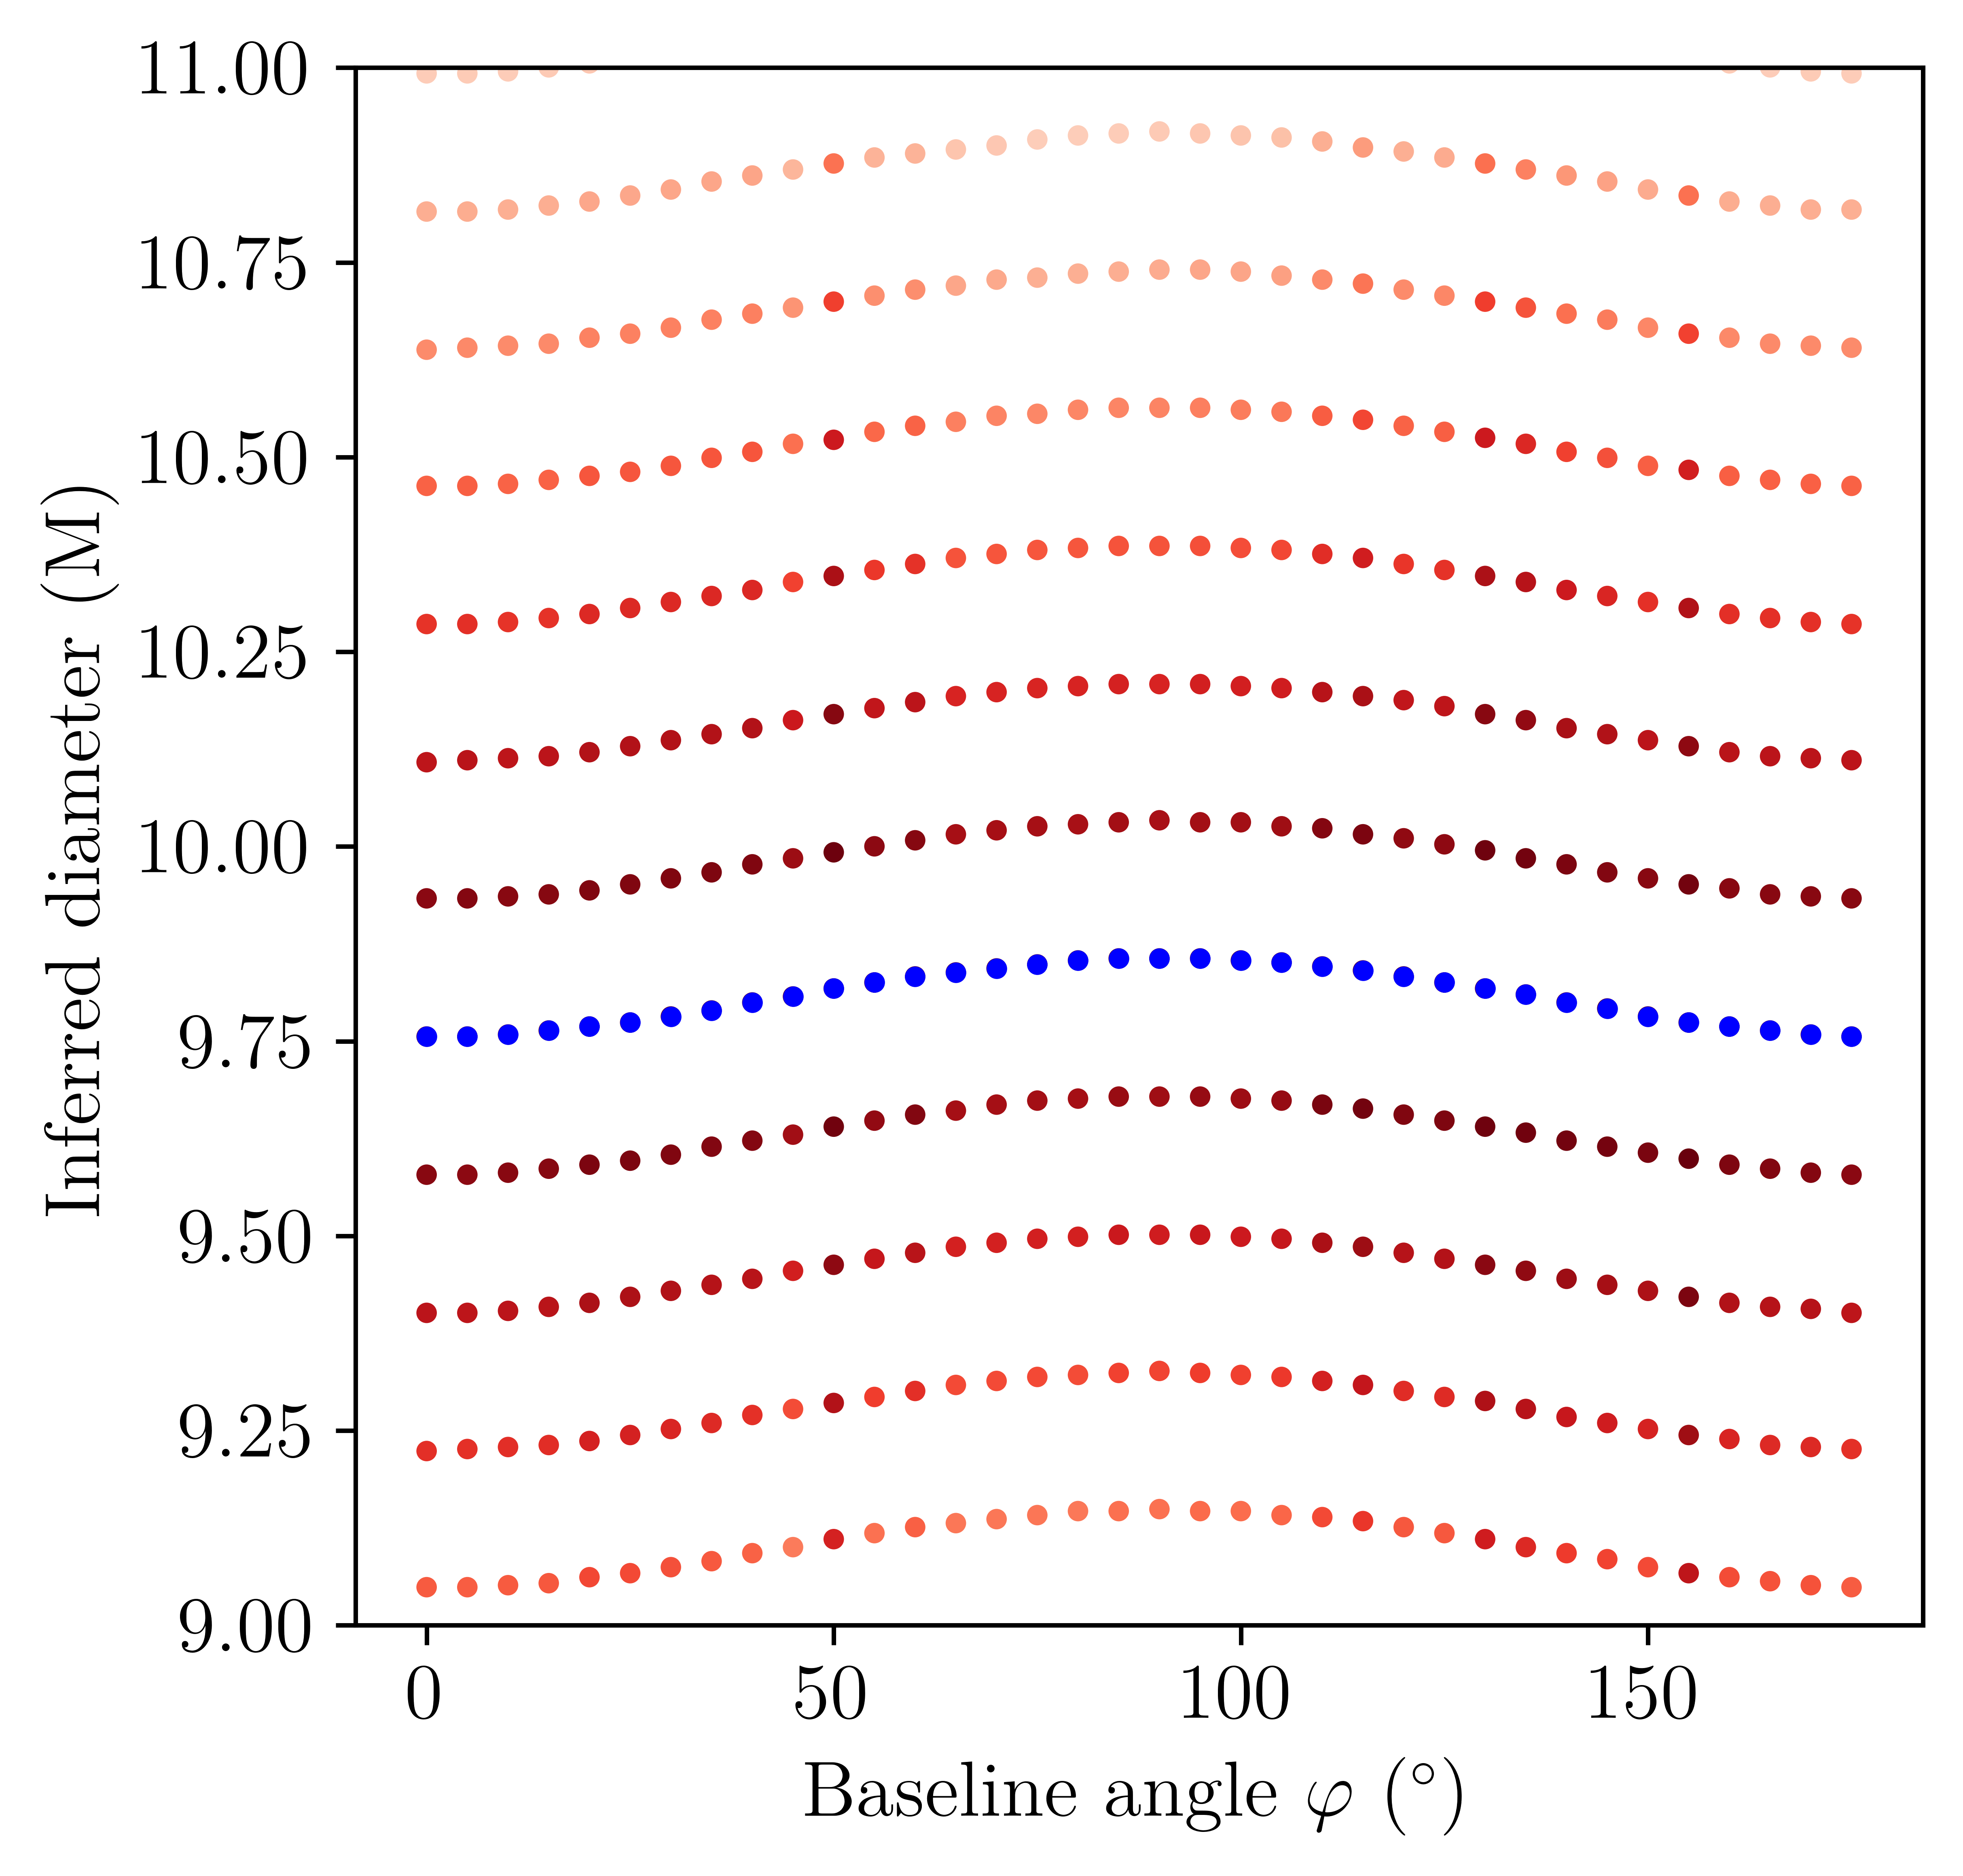

In [33]:
fig, ax = plt.subplots(figsize=[5,5],dpi=1000)

d_vals=npz_s_0['d_vals']
g_vals=npz_s_0['g_vals']

# ax.plot(drange, g_vals, linewidth=0.5)
for i in range(0, len(d_vals)):
    darray = d_vals[i]
    ax.scatter([radonangles[i] for j in range(0, len(darray))], np.array(darray)/M_to_muas, c=g_vals[i], cmap='Reds', s=7)
    
ax.scatter(radonangles, npz_s_0['mu']/M_to_muas, label="Most probable circlipse", s=7, c='b')
plt.xlabel('Baseline angle $\\varphi$ $(^\circ)$', size=14)
plt.ylabel("Inferred diameter (M)", size=14)
# plt.savefig('circlipse_spin_94_ex.pdf',dpi=1000,bbox_inches='tight')
    
plt.xlabel("Baseline angle $\\varphi$ $(^\circ)$", size=14)
plt.ylabel("Inferred diameter (M)",size=14)
plt.ylim(9,11)
plt.savefig(fig_path+'diameter_baseline_a_%s_i_%s_gfit_min_%s_noise_%s_ulim1_%s_ulim2_%s.pdf'%(spins[1], inclinations[0], gfit_min, s_n, ulim1_fit, ulim2_fit),dpi=1000,bbox_inches='tight')
# plt.savefig('diameter_baseline_spin_94_ex.pdf',dpi=1000,bbox_inches='tight')
plt.show()

We see in this plot that for each baseline angle there are several inferred diameters due to the aformentioned degeneracy. Note that if one desires a more accurate $d_{||}$ and $d_\perp$, then the increments between the diameters in the range [8M, 12M] considered as 'true' diameters can be decreased, which would serve to decrease the separation between the several curves seen in the plot above. To do this, one can modify the _drange_ array in line 245 in the radialfit.py file by decreasing the default diameter separation value of $0.01\mu$as. However, the marginal increase in accuracy would come at the cost of an increased running time, and may not be worth it if performing a large number of fits.

Returning to the plot above, one can see multiple shapes called 'circlipses', and it's from the 'best' circlipse (blue) that the diameters $d_{||}$ and $d_{\perp}$ are computed. The 'best' circlipse is that with the highest goodness of fit, a measure of the total RMSD of each constituent diameter in the circlipse. The 'best' circlipse is  plotted in the cell below.

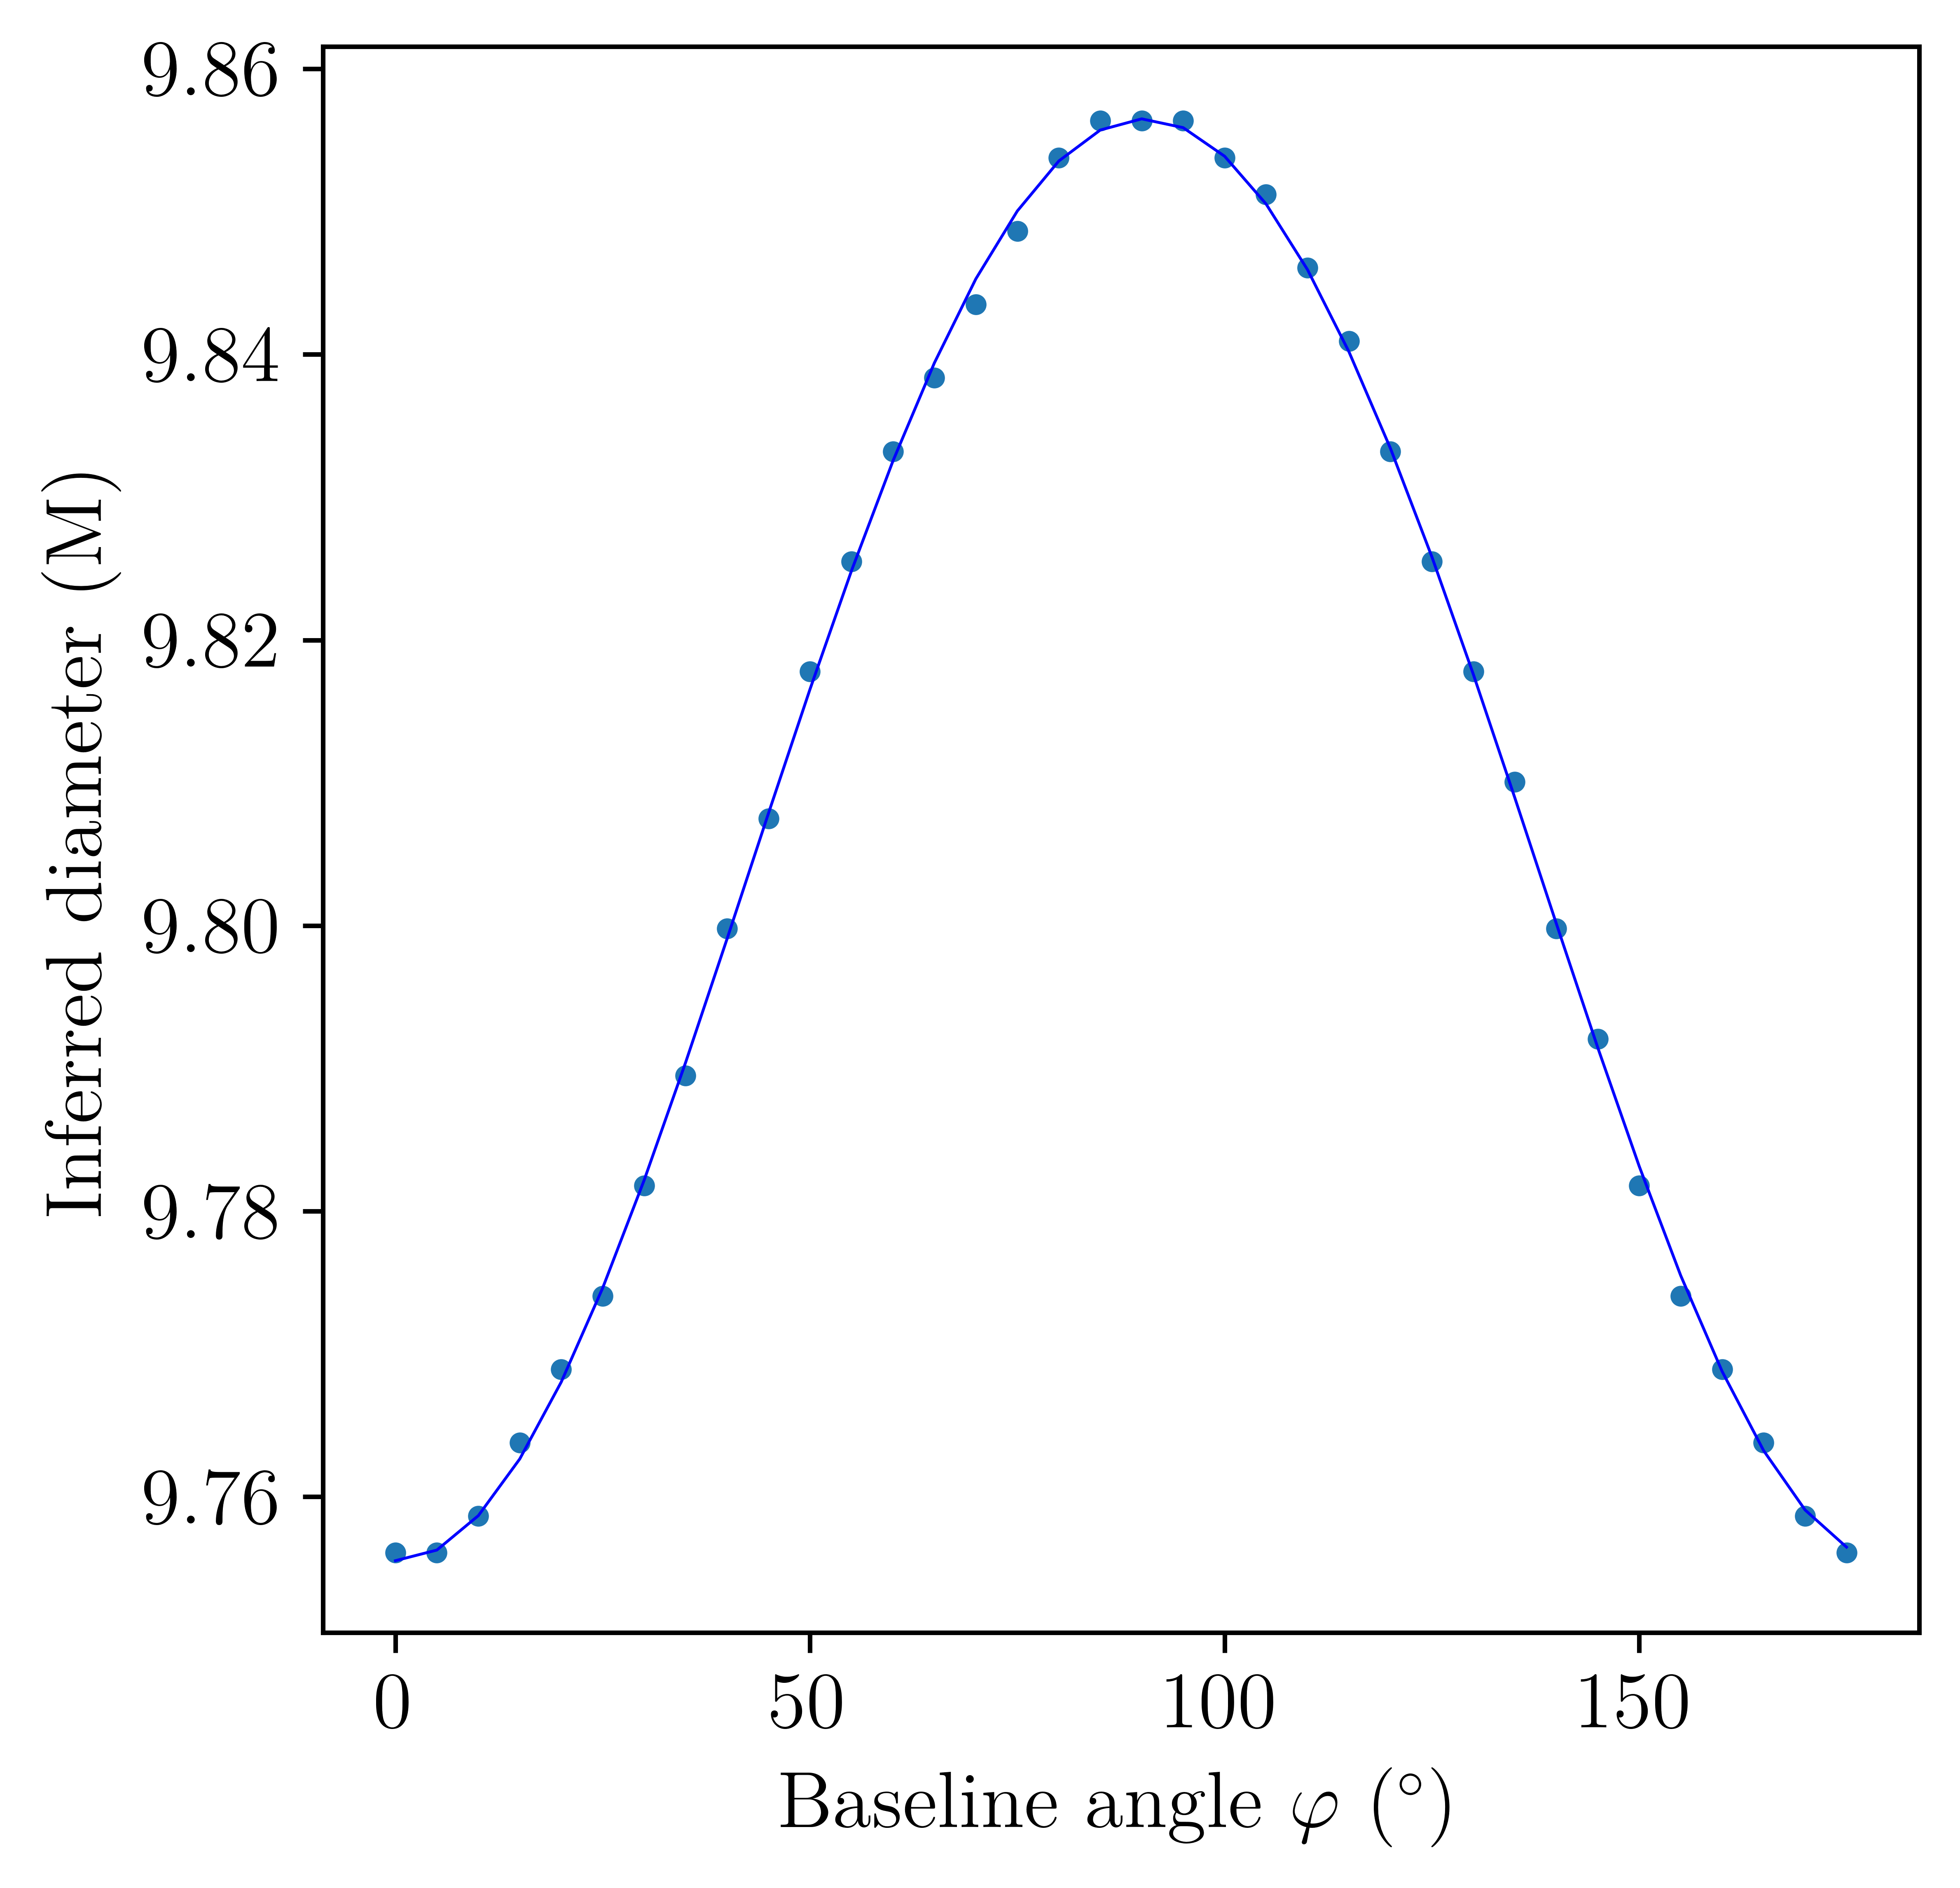

In [34]:
fig, ax = plt.subplots(figsize=[5,5],dpi=1000)
ax.scatter(radonangles, npz_s_0['mu']/M_to_muas, label="Most probable circlipse", s=7)
ax.plot(radonangles, [rf.circlipse(phi*np.pi/180, *npz_s_0['fit'])/M_to_muas for phi in radonangles], linewidth=0.5, c='b', label="d_fit")
plt.xlabel('Baseline angle $\\varphi$ $(^\circ)$', size=14)
plt.ylabel("Inferred diameter (M)", size=14)
plt.savefig(fig_path+'circlipse_a_%s_i_%s_gfit_min_%s_noise_%s_ulim1_%s_ulim2_%s.pdf'%(spins[1], inclinations[0], gfit_min, s_n, ulim1_fit, ulim2_fit),dpi=1000,bbox_inches='tight')

This circlipse shape obeys the functional form
\begin{align}
    d_{\text{fit}}(\varphi;\mathbf{R})&=2R_{0}+2\sqrt{R_{1}^{2}\sin^{2}{(\varphi-\varphi_0)}+R_{2}^{2}\cos^{2}{(\varphi-\varphi_0)}},\label{circlipse}
\end{align}
with fitting parameters $\mathbf{R}=\{R_0, R_1, R_2, \varphi_0\}$. In our case, the best fit parameters are printed in the cell below.

In [35]:
params_s_0=npz_s_0['fit']
print("*** Circlipse params***")
print("R0 = "+'{:.4}'.format(params_s_0[0]/2))
print("R1 = "+'{:.3}'.format(params_s_0[1]/2))
print("R2 = "+'{:.3}'.format(params_s_0[2]/2))
print("phi0 = "+'{:.3}'.format(params_s_0[3]))

*** Circlipse params***
R0 = 9.02
R1 = 0.564
R2 = 0.466
phi0 = 0.00529


From the fitting parameters, we can calculate $d_{\perp}$ and $d_{||}$ from the relations
\begin{align}
    d_{\perp}&=2(R_0+R_2),\\
    d_{||}&=2(R_0+R_1),
\end{align}
which, together, define the fractional asymmetry 
\begin{align}
    f_{A}\equiv 1-\frac{d_{\perp}}{d_{||}}\label{asym}.
\end{align}

In [36]:
d_perp_s_0=observables_s_0[0]*M_to_muas
d_para_s_0=observables_s_0[1]*M_to_muas
f_a_s_0=100 * observables_s_0[2]
rmsda_s_0=npz_s_0['rmsda']

In [37]:
print("*** units of M***")
print("d_perp = " + str(d_perp_s_0/M_to_muas))
print("d_para = " + str(d_para_s_0/M_to_muas))
print("\n*** units of muas ***")
print("d_perp = " + str(d_perp_s_0))
print("d_para = " + str(d_para_s_0))
print("f_a = " + str(f_a_s_0) + "%") ## as a percentage
print("\nRMSD = "+'{:.2e}'.format(rmsda_s_0))
# print("d= "+'{:.6}'.format(npz['d_0_vals'][0]))

*** units of M***
d_perp = 9.75552378282237
d_para = 9.856496067372904

*** units of muas ***
d_perp = 37.94264568588563
d_para = 38.33536223315511
f_a = 1.0244237288824398%

RMSD = 7.85e-05


To see how accurate our fitting method is in this example, we compare our computed $n=2$ photon ring diameters to the critical curve diameters to see how well the former approximates the latter.

In [38]:
# extract critical curve diameters from lensing bands file
fnbands=bh_obs_data_path+"LensingBands_a_%s_i_%s_dx0_%s_dx1_%s_dx2_%s.h5"%(spins[mask1], inclinations[mask2], params['dx0'], params['dx1'], params['dx2'])
h5f = h5py.File(fnbands,'r')

alpha_critc=h5f['alpha'][:]
beta_critc=h5f['beta'][:]
d_perp_shadow = min(alpha_critc[-1]-alpha_critc[0], 2*beta_critc.max())
d_para_shadow = max(alpha_critc[-1]-alpha_critc[0], 2*beta_critc.max())

print("*** critical curve diameters (M) ***")
print("d_perp_critical = "+str(d_perp_shadow))
print("d_para_critical = "+str(d_para_shadow))

*** critical curve diameters (M) ***
d_perp_critical = 9.732088398514307
d_para_critical = 9.83277393214495


In [39]:
print("*** % difference between predicted diameters and critical curve diameters ***")
print("d_perp: "+str(100*(1-(d_perp_s_0/M_to_muas)/d_perp_shadow))+"%")
print("d_para: "+str(100*(1-(d_para_s_0/M_to_muas)/d_para_shadow))+"%")

*** % difference between predicted diameters and critical curve diameters ***
d_perp: -0.24080529633949688%
d_para: -0.2412557777861979%


The diameters $d_{\perp}$, and $d_{||}$ describe the shape of the photon ring, while the spin of the black hole and the observer inclination can be inferred from $d_{||}$ and $f_A$ together, which is done in a simplified manner in the next section. 

# Predicting the spin and inclination of a BH

Demonstrated in this section is a simplified way of predicting the spin and inclination of a BH. For details see Ref. [2]. 

We make use of precomputed data generated by AART (see example code at the end of this noteboook). The data consists of calculated parallel diameter $d_{||}$ and fractional asymmetry $f_A$ pairs of the theoretical black hole critical curve for $38\times38=1444$ spin-inclination pairs $(a, i)$. Since we specify the BH profile when running the simulations above, we already know $(a, i)$ for each diameter-asymmetry pair. Using all this information, we create a contour plot of spin against inclination, with two distinct sets of contour levels: 1) parallel diameter $d_{||}$ contours (solid red in the plot below), and 2) fractional asymmetry $f_A$ contours (solid blue in the plot below). 

As a final step, we manually set two new levels on the contour plot (both dashed on the plot below), one for each of ($d_{||}, f_A$) of the $n=2$ photon ring that we calculated earlier in this notebook from the visibility amplitude. The point of intersection of these two (dashed) contours predicts a spin and inclination of the BH that generated the visibility amplitude profile. Of course, we already know the exact spin-inclination pair because he had to specify that in order to produce the visibility amplitude, but in a real experiment we would measure the visibility profile without knowing a priori the spin and inclination, and then we'd use this profile to try and infer these parameters of the BH.

We begin by loading the data from the precomputed data in the files `dpara_BH_shadow.txt` and `asym_BH_shadow.txt`.

In [40]:
# range of spins and inclinations used to generate data
contour_spins=np.linspace(0.01, 0.99, 38)
contour_angles=np.linspace(1, 89, 38)

# load data
dpara = np.loadtxt('dpara_BH_shadow.txt')
asym = np.loadtxt('asym_BH_shadow.txt')

We now make the contour plot.

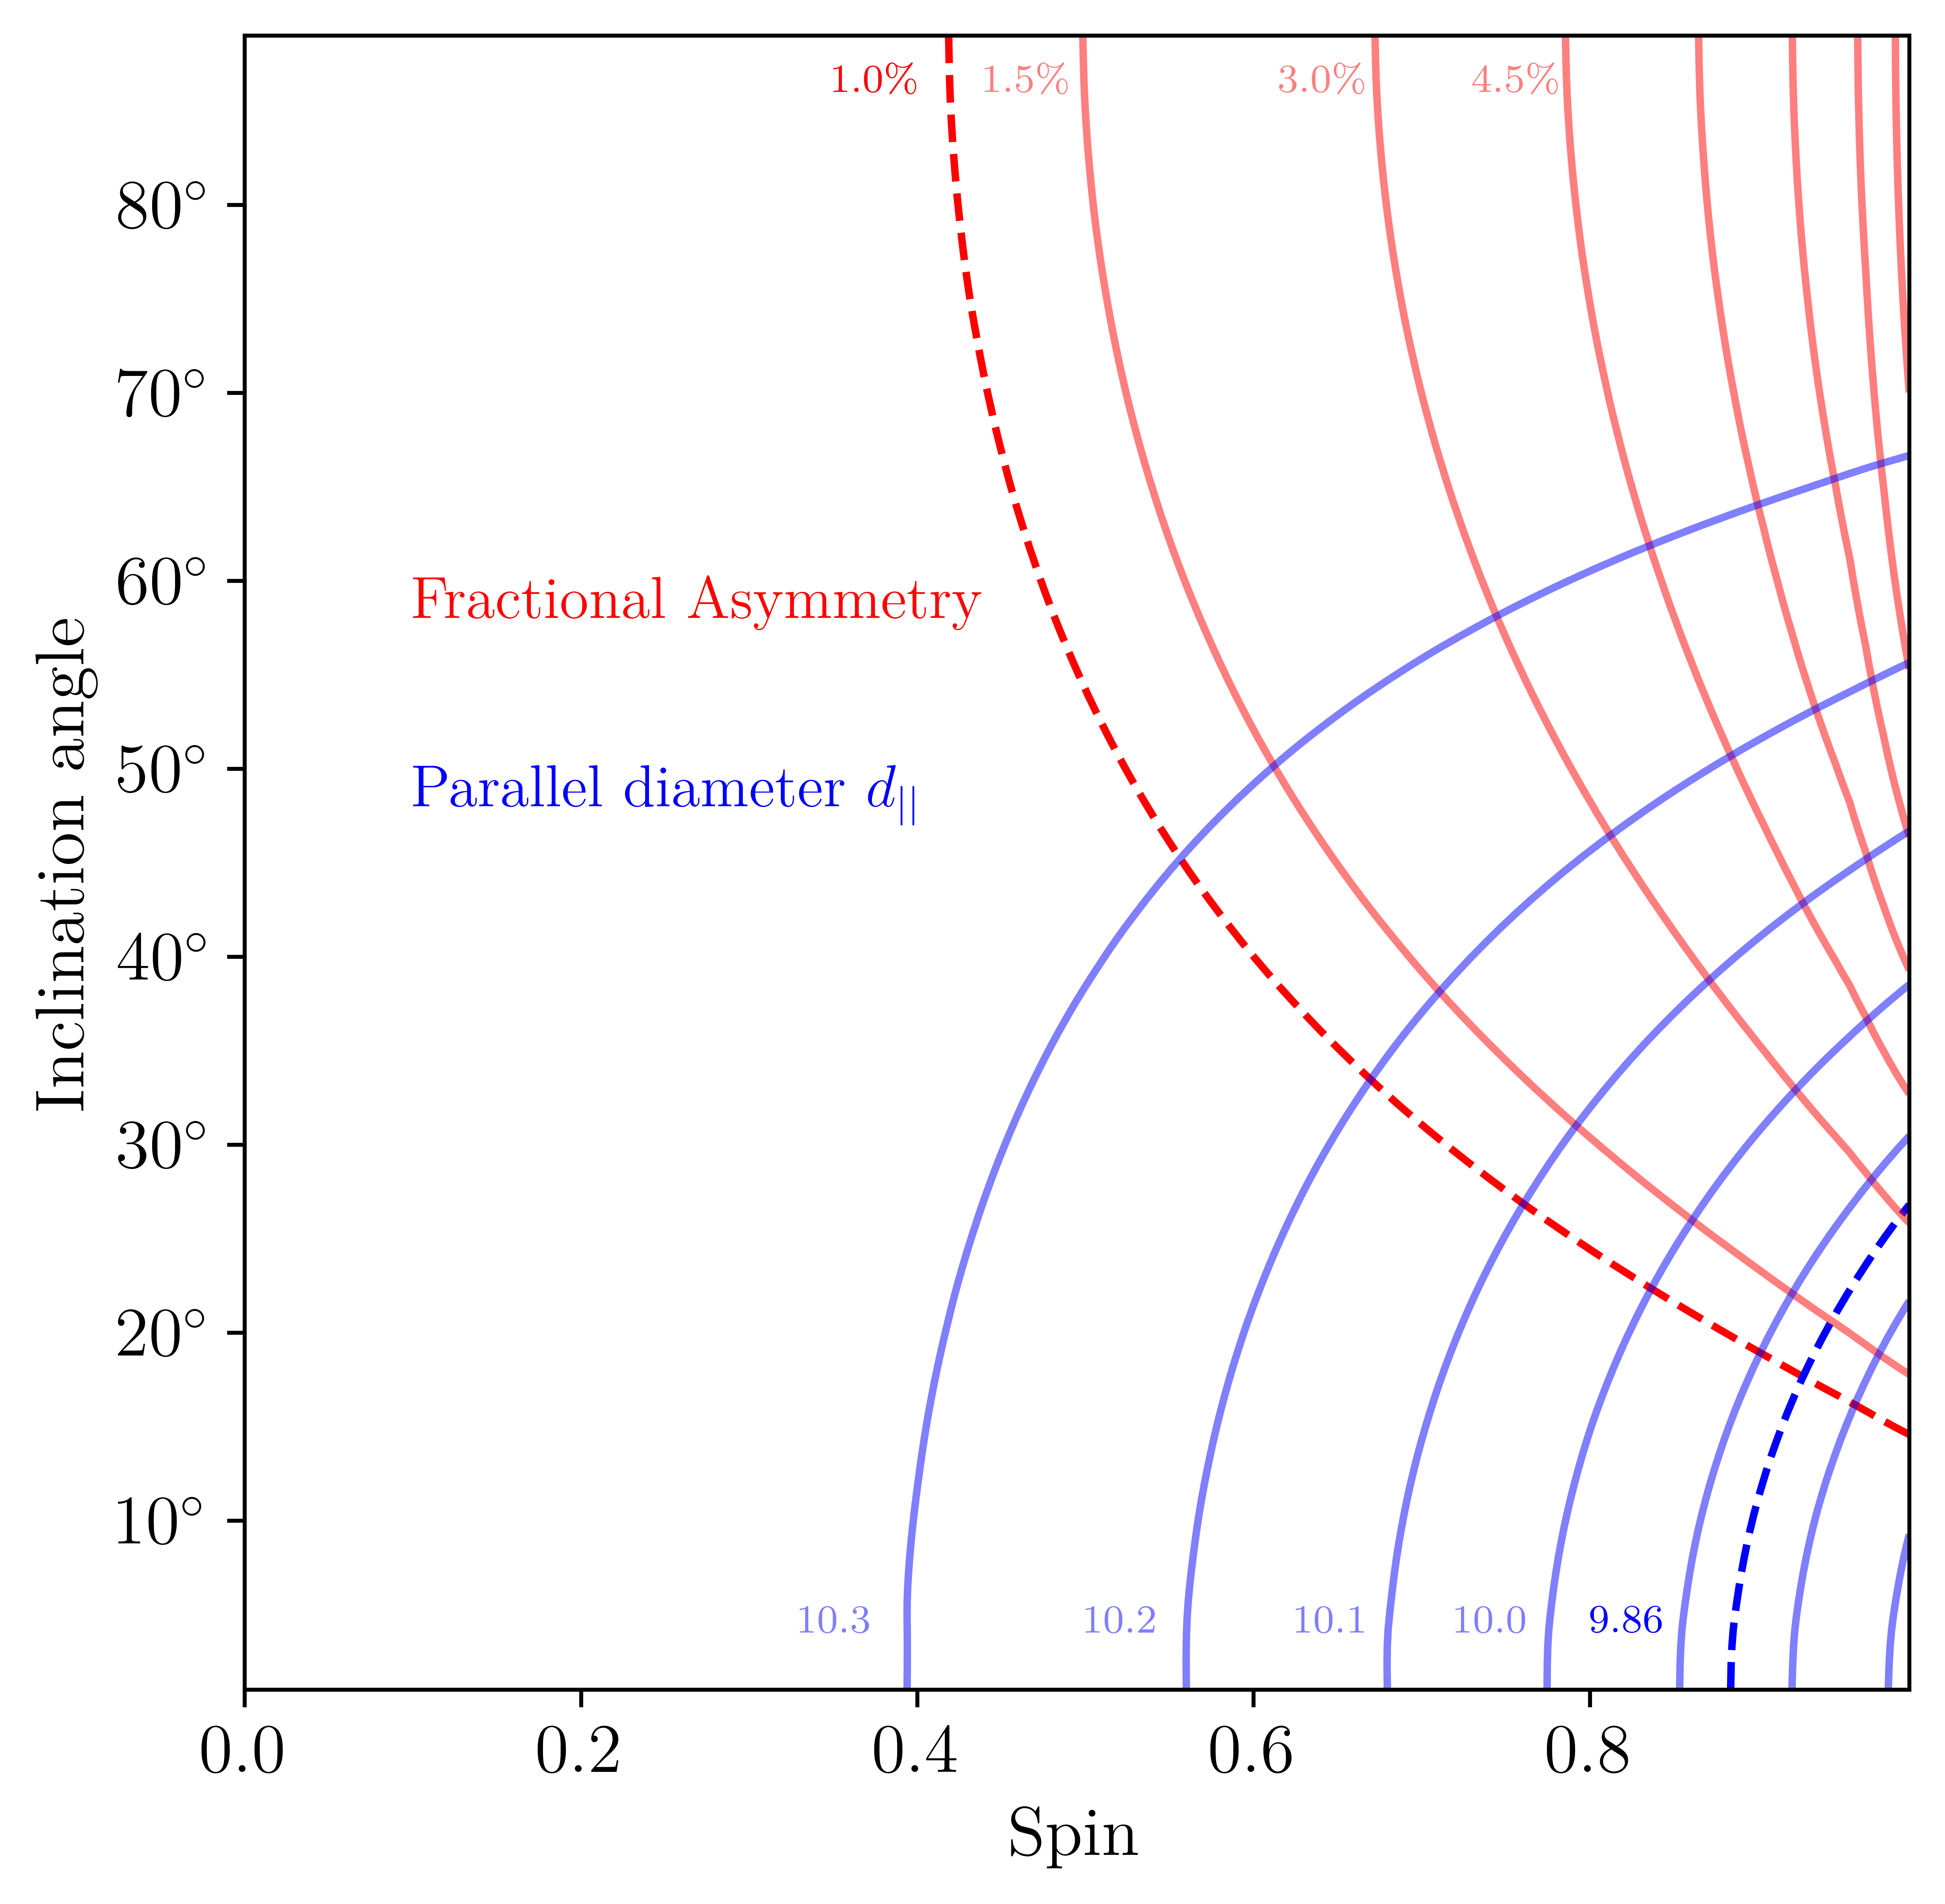

In [41]:
# plot
A, I = np.meshgrid(contour_spins, contour_angles)
pw=3
Asm = zoom(A, pw, order=2)
Ism = zoom(I, pw, order=2)
Dsm = zoom(dpara, pw, order=2)
Fsm = zoom(asym, pw, order=2)

fig, ax = plt.subplots(figsize=(6,6),dpi=1000)
CS1 = ax.contour(Asm, Ism, np.transpose(Fsm), colors='r',levels=[f_a_s_0],linestyles="dashed")
# positions1 = [(0.40,83), (0.62,83), (0.81,83)]
# labels1 = ax.clabel(CS1, inline=True, fontsize=6, fmt='%.1f %%', manual=positions1)
CS2 = ax.contour(Asm, Ism, np.transpose(Dsm), colors='b',levels=[d_para_s_0/M_to_muas],linestyles="dashed")
# positions2 = [(0.40,6), (0.62, 6), (0.7, 6), (0.81,6), (0.85, 6), (0.9, 6)]
# labels2 = ax.clabel(CS2, inline=True, fontsize=6, manual=positions2)
CS3 = ax.contour(Asm, Ism, np.transpose(Fsm), colors='r',alpha=0.5)
CS4 = ax.contour(Asm, Ism, np.transpose(Dsm), colors='b',alpha=0.5)
ax.set_xlabel('Spin', size=14)
ax.set_ylabel('Inclination angle', size=14)
# for l in labels1+labels2:
#     l.set_rotation(0)
plt.annotate('Fractional Asymmetry',(0.1,58), color='r', fontsize=12)
plt.annotate('1.5\%',(0.44,86), color='r', fontsize=8, alpha=0.5)
plt.annotate('3.0\%',(0.615,86), color='r', fontsize=8, alpha=0.5)
plt.annotate('4.5\%',(0.73,86), color='r', fontsize=8, alpha=0.5)
plt.annotate('Parallel diameter $d_{||}$',(0.1,48), color='b', fontsize=12)
plt.annotate('10.3',(0.33,4), color='b', fontsize=8, alpha=0.5)
plt.annotate('10.2',(0.5,4), color='b', fontsize=8, alpha=0.5)
plt.annotate('10.1',(0.625,4), color='b', fontsize=8, alpha=0.5)
plt.annotate('10.0',(0.72,4), color='b', fontsize=8, alpha=0.5)
plt.annotate('1.0\%', (0.35, 86), color='r', fontsize=8)
plt.annotate('9.86', (0.80, 4), color='b', fontsize=8)
plt.xticks(np.arange(0, 1.0, 0.2))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%d$^{\circ}$'))
plt.savefig('contour_plot.pdf',dpi=1000,bbox_inches='tight')
plt.show()

We now compute the intersection point of the two dashed contours

In [42]:
!pip install shapely

In [43]:
from shapely import geometry

def findIntersection(contour1,contour2):
    p1 = contour1.collections[0].get_paths()[0]
    v1 = p1.vertices

    p2 = contour2.collections[0].get_paths()[0]
    v2 = p2.vertices

    poly1 = geometry.LineString(v1)
    poly2 = geometry.LineString(v2)

    intersection = poly1.intersection(poly2)

    return intersection

In [44]:
intersection_example = findIntersection(CS1,CS2)

In [45]:
print("predicted spin = "+str(intersection_example.x))
print("predicted inclination = "+str(intersection_example.y))

predicted spin = 0.9268017251600364
predicted inclination = 17.64702652735924


As we can see the predicted spin and inclination are close to the actual parameters $a=0.94, i=17^\circ$ of the BH which we know a priori since we simluated the visibility profiles. The prediction should become more accurate if we increase the resolutions dx0, dx1, and dx2 in the appropriate functions above (e.g `lb.clb`). 

It's important to note that this method is indeed simplified since we ignore the effects of instrumental and astrophysical noise, which would significantly increase the uncertainty in any prediction of the spin or inclination of a BH.

## Example code to generate contour data using AART

```
# generate lensing bands data
contour_spins=np.linspace(0.01, 0.99, 38)
contour_angles=np.linspace(1, 89, 38)
%time lb.clb(contour_spins, contour_angles, dx0=0.1, dx1=0.1,dx2=0.1, path=bh_obs_data_path)

# extract diameters of critical curve
dpara=[]
asym=[]
for a in spins:
    d_a=[]
    f_A=[]
    for i in angles:
        fnbands=bh_obs_data_path+"LensingBands_a_%s_i_%s.h5"%(spin_case,i_case)
        h5f = h5py.File(fnbands,'r')
        
        #Points for the boundary of the BH shadow
        alpha_critc=h5f['alpha'][:]
        beta_critc=h5f['beta'][:]
        d_perp_shadow = min(alpha_critc[-1]-alpha_critc[0], 2*beta_critc.max())
        d_para_shadow = max(alpha_critc[-1]-alpha_critc[0], 2*beta_critc.max())
        f_a = (1-d_perp_shadow/d_para_shadow)*100
        d_a.append(d_para_shadow)
        f_A.append(f_a)
    dpara.append(d_a)
    asym.append(f_A)
  
# save diameter data  
np.savetxt(bh_obs_data_path+"dpara_BH_shadow.txt", dpara)
np.savetxt(bh_obs_data_path+"asym_BH_shadow.txt", asym)

# load diameter data
dpara = np.loadtxt(bh_obs_data_path+'dpara_BH_shadow.txt')
asym = np.loadtxt(bh_obs_data_path+'asym_BH_shadow.txt')
```

# References

[1] Cardenas-Avendano, A., Lupsasca, A. & Zhu, H. Adaptive Analytical Ray Tracing of Black Hole Photon Rings. [arXiv:2211.07469](https://arxiv.org/abs/2211.07469)

[2] M. D. Johnson et al., Universal interferometric signatures of a black hole’s photon ring,
Science Advances 6 (2020). [arXiv:1907.04329](https://arxiv.org/abs/1907.04329)